# Audio

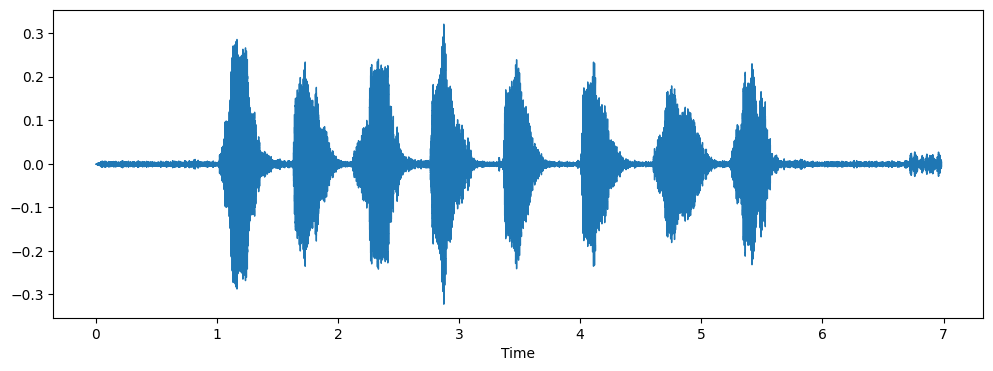

In [1]:
import librosa
import matplotlib.pyplot as plt

file_audio = './datasets/waves_yesno 2/0_1_0_1_1_1_0_0.wav'
y, sr = librosa.load(file_audio)
fig, ax = plt.subplots(nrows=1, sharex=True, figsize = (12, 4))
librosa.display.waveshow(y, sr=sr);

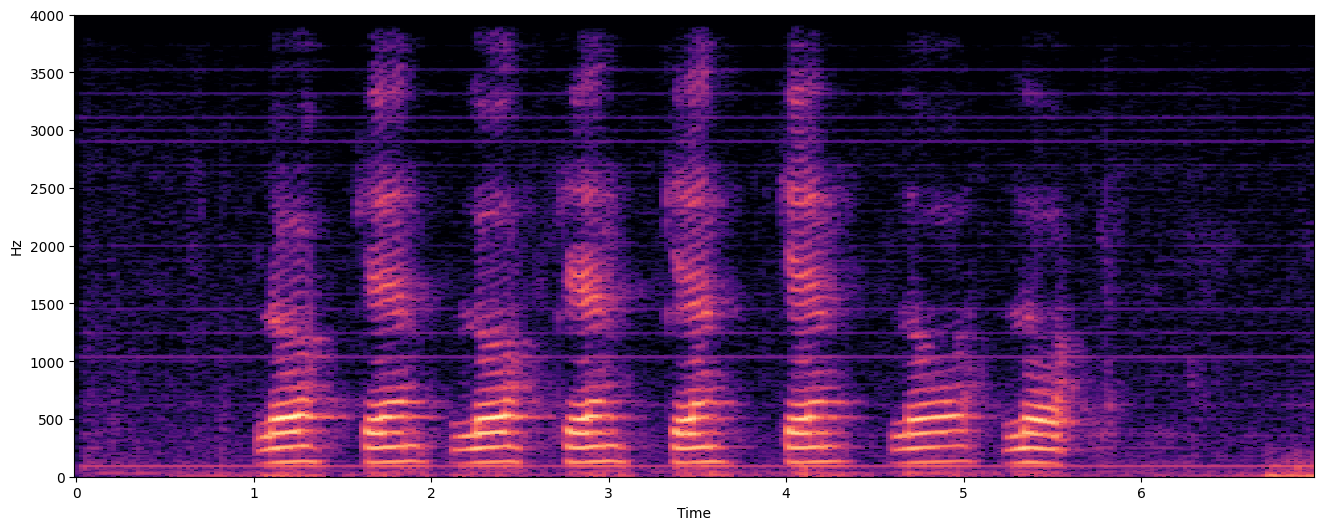

In [2]:
import numpy as np

fig, ax = plt.subplots(nrows=1, sharex=True, figsize = (16, 6))
ax.set_ylim([0, 4000])
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr)

In [3]:
def load_dataset(directory: str):
    sr = None
    X, labels, files = [], [], []
    for f in glob(directory + "/*.wav"):
        filename = os.path.basename(f)
        name = filename[:-4]
        y = [int(label) for label in name.split("_")]
        x, sr = librosa.load(f)
        X.append(x)
        labels.append(y)
        files.append(filename)

    return X, labels, sr, files

In [4]:
from glob import glob
import os
from sklearn.model_selection import train_test_split

X, labels, sr, files = load_dataset('./datasets/waves_yesno 2/')
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.2, random_state = 42)
print(f'Train = {len(X_train)}')
print(f'Test = {len(X_test)}')

Train = 47
Test = 12


Определение сегмента записи Voice Activity Detection (VAD)

In [5]:
vad_segments = [[] for i in range (len(files))]

for i in range (len(files)):
    file_audio = '../datasets/waves_yesno 2/' + files[i]
    audio, sample_rate = librosa.load(file_audio)
    speech_segment = librosa.effects.split(audio, top_db=13)
    vad_segments[i] = speech_segment

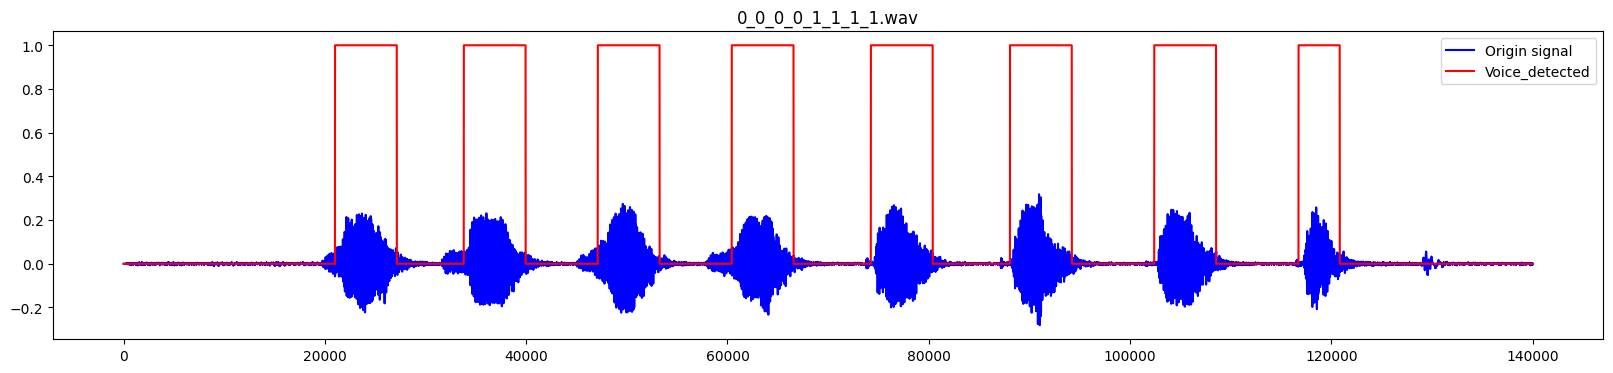

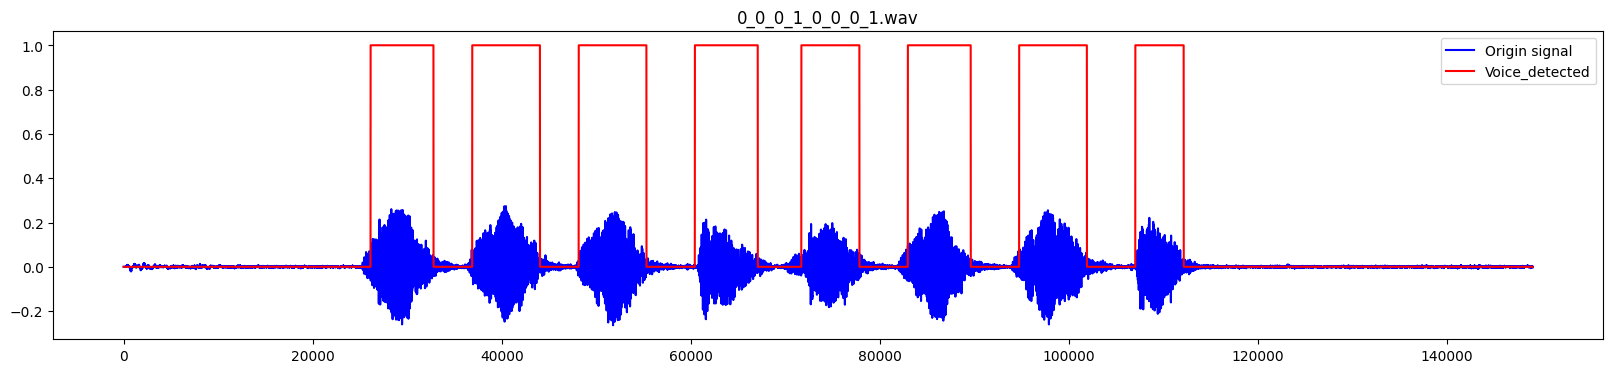

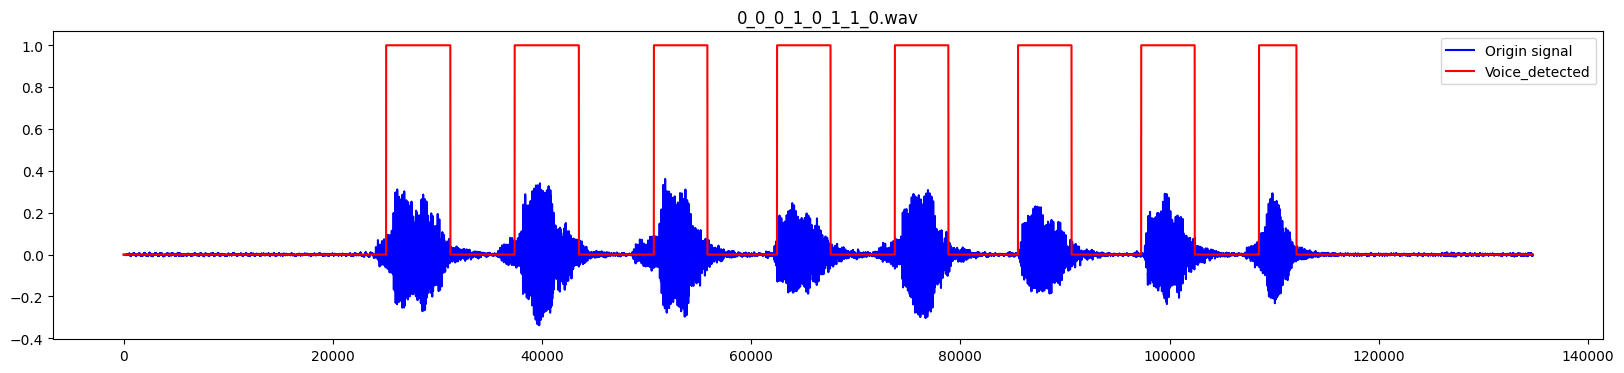

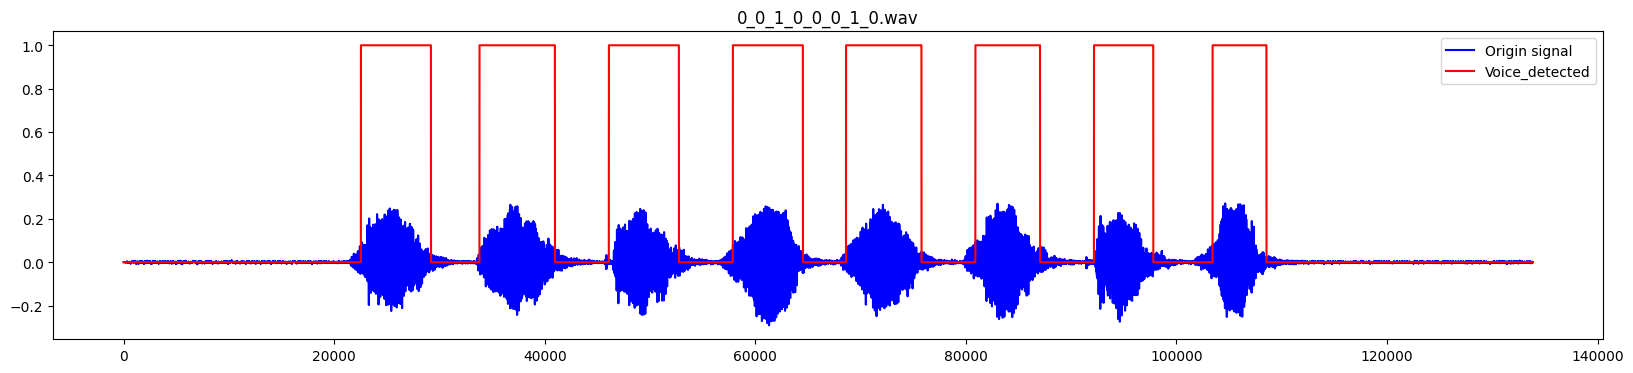

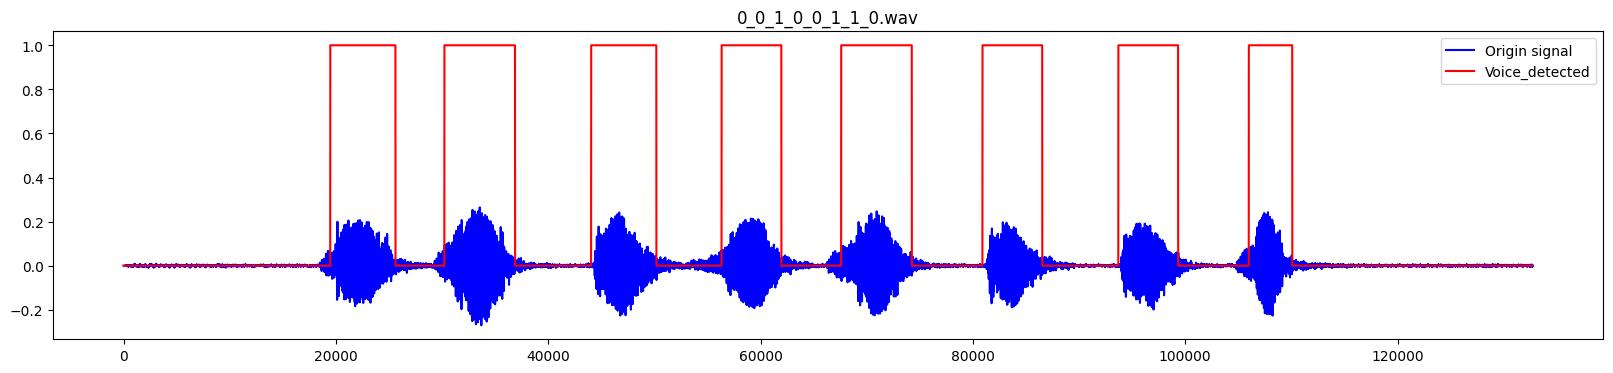

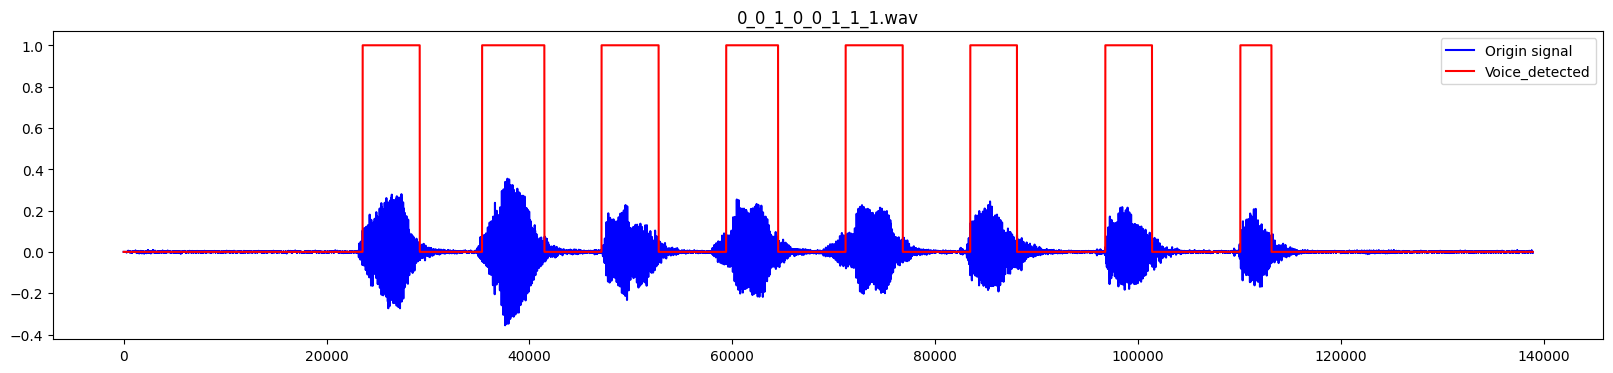

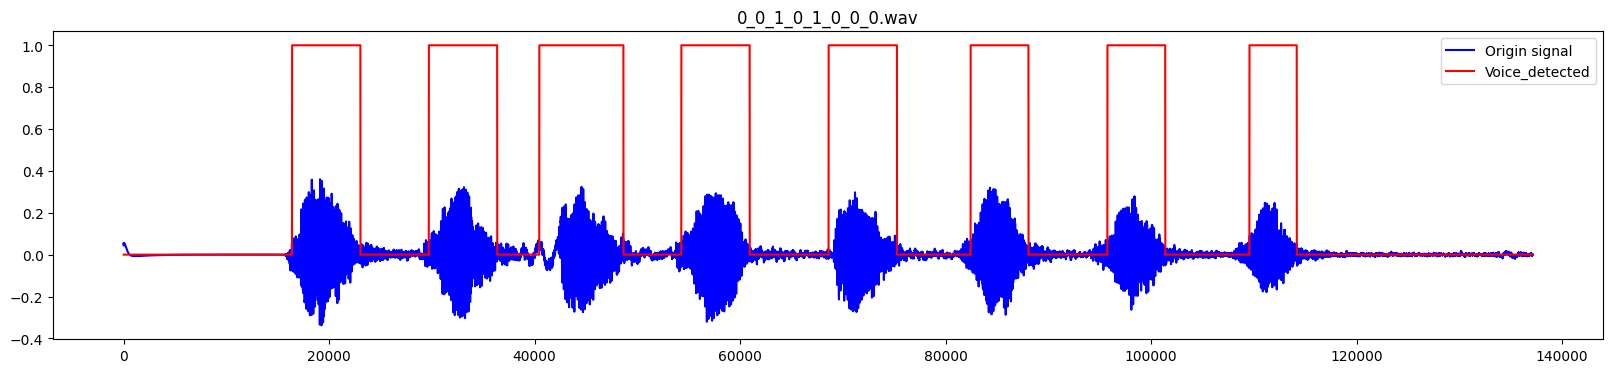

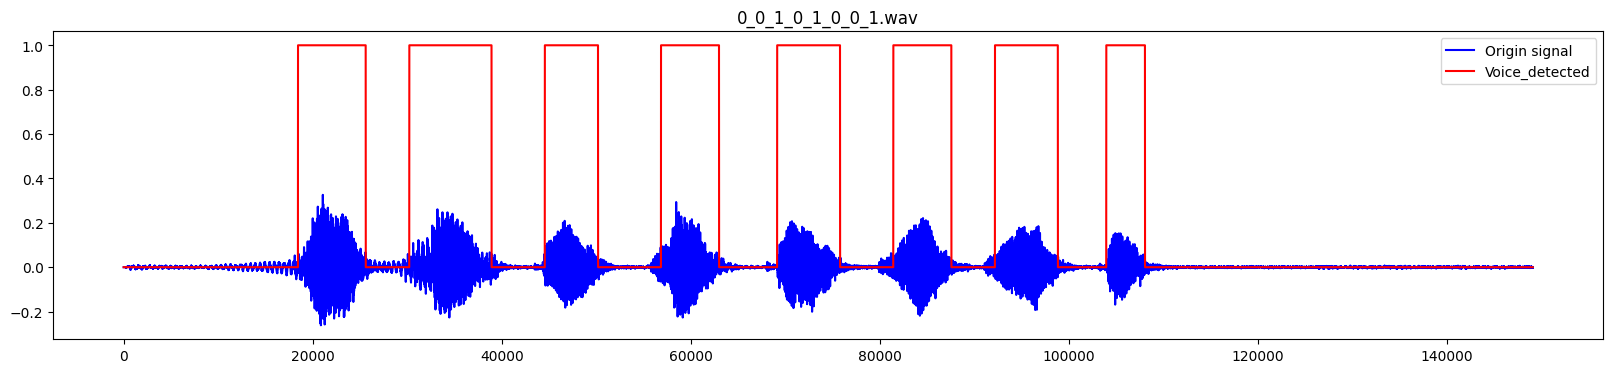

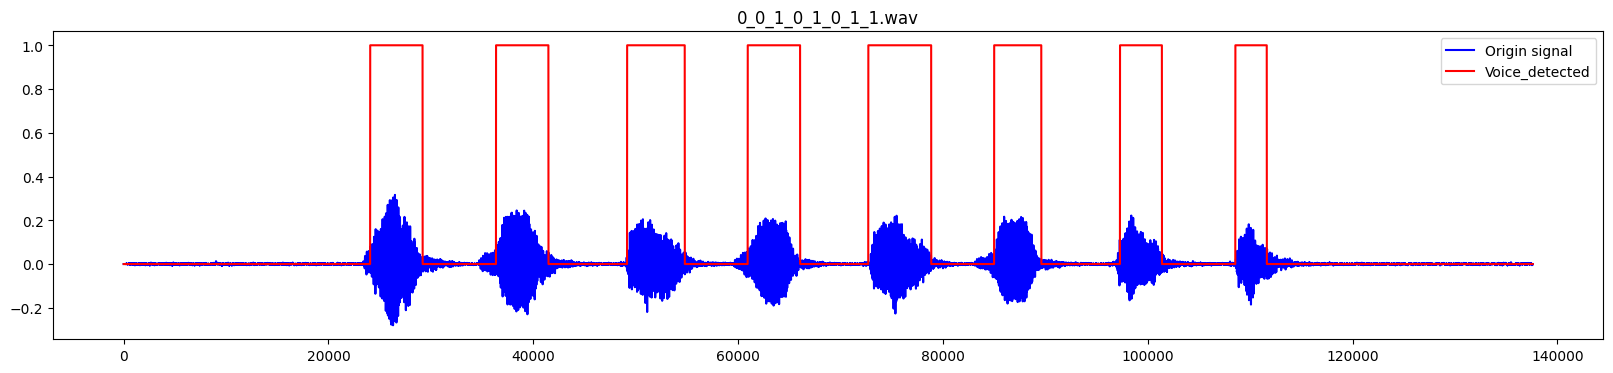

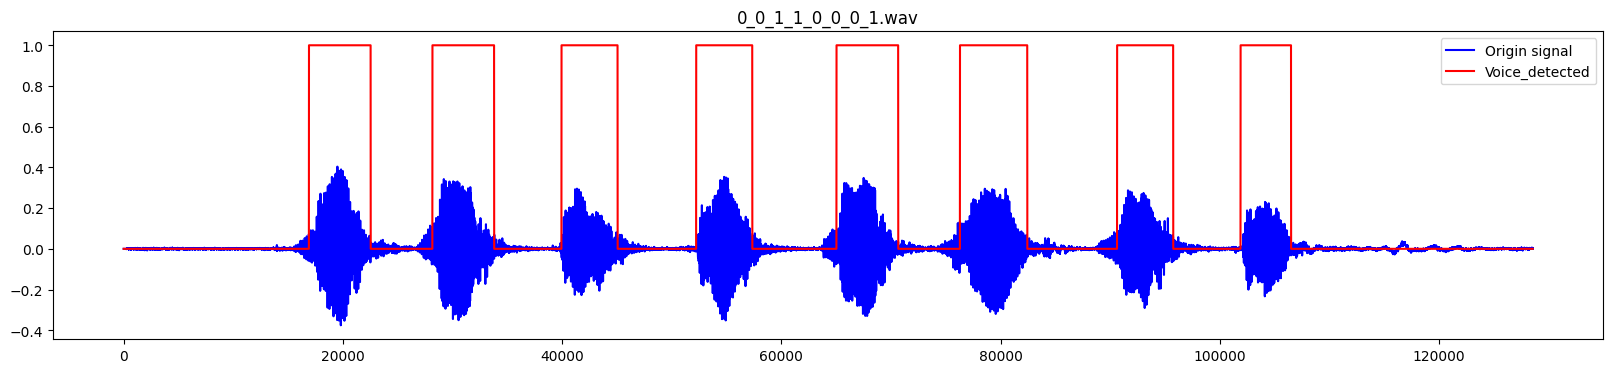

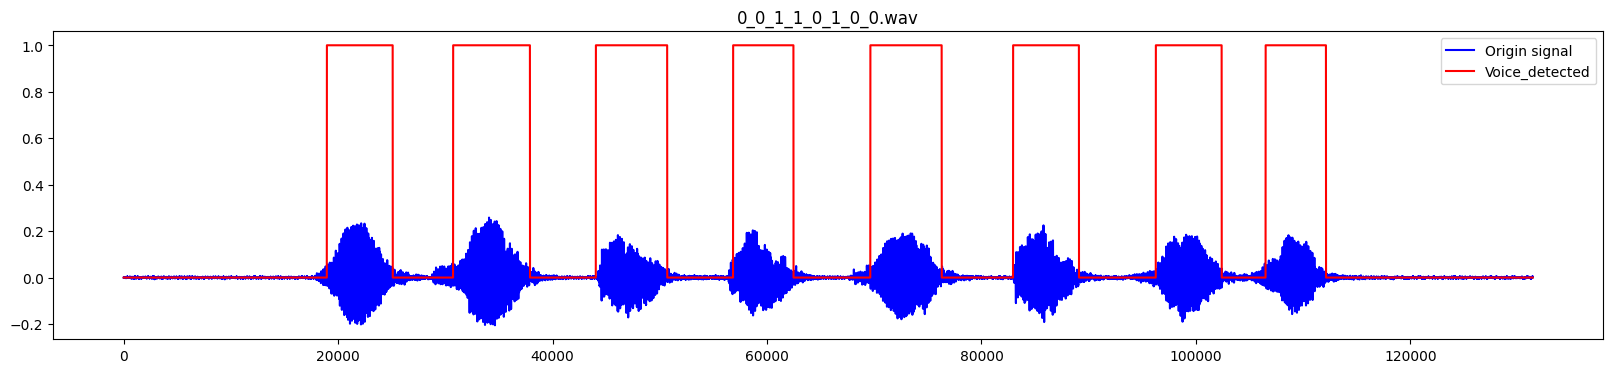

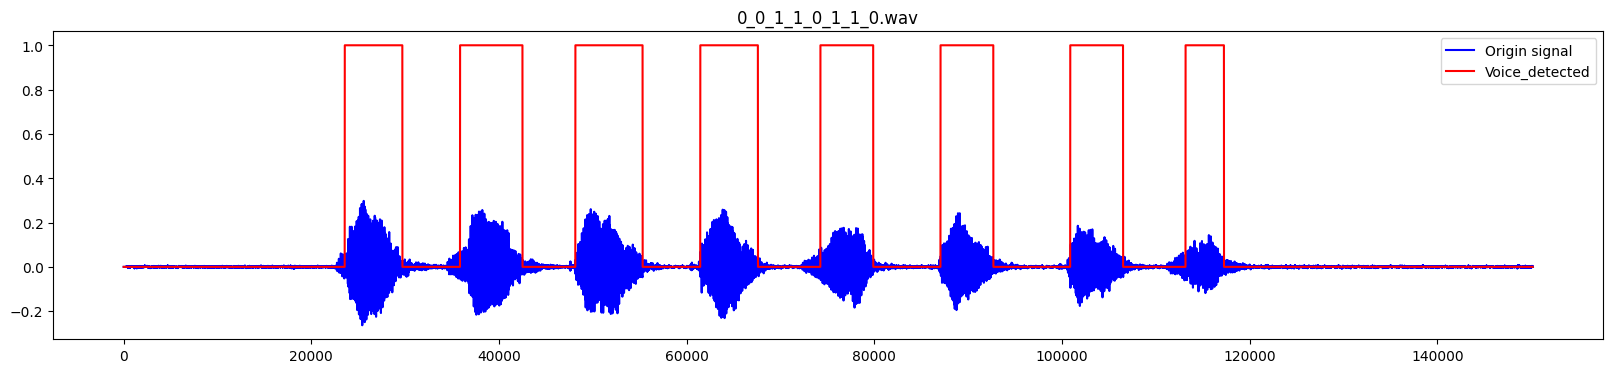

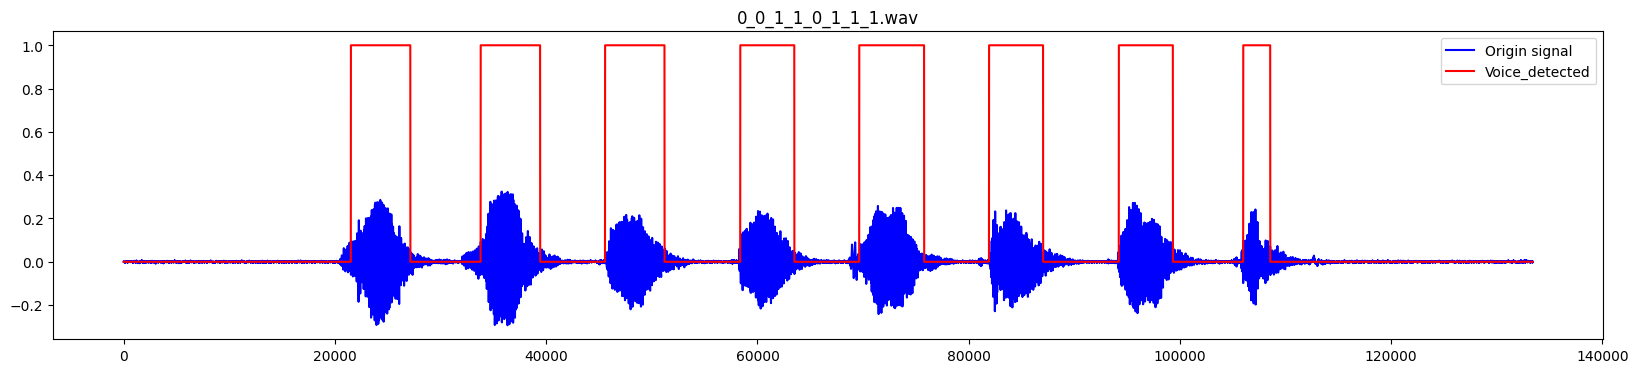

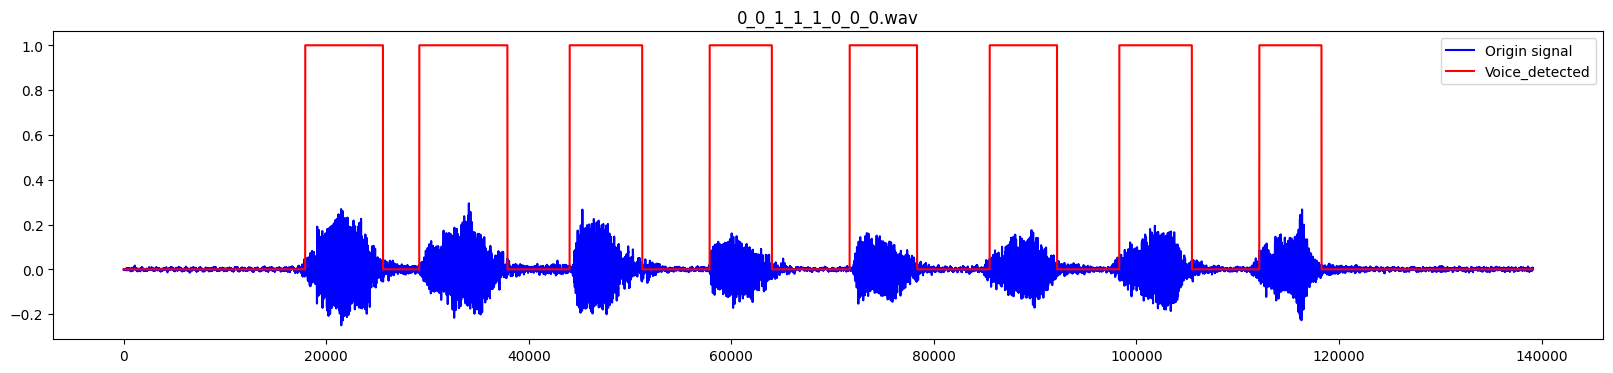

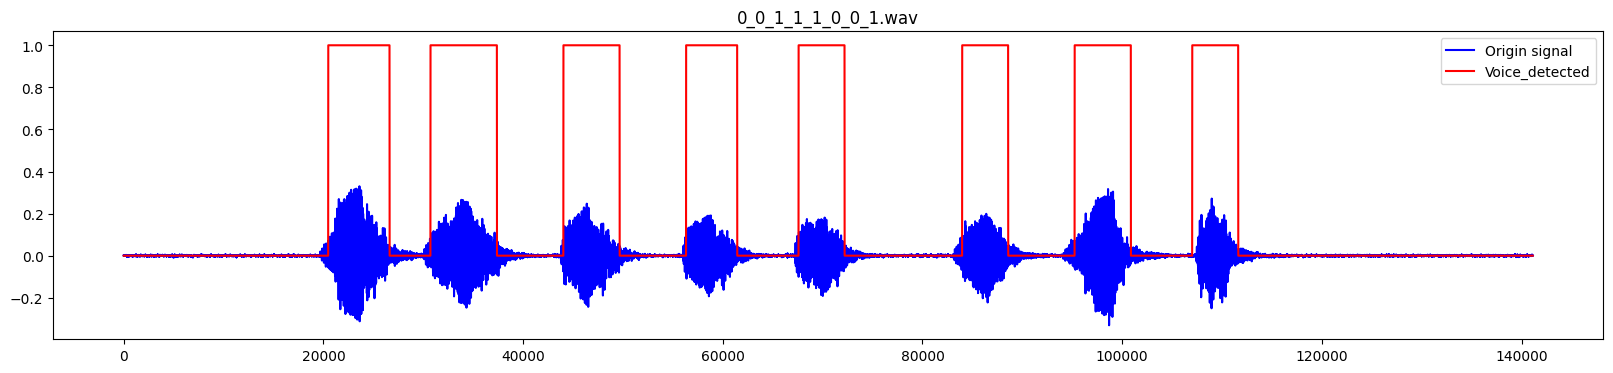

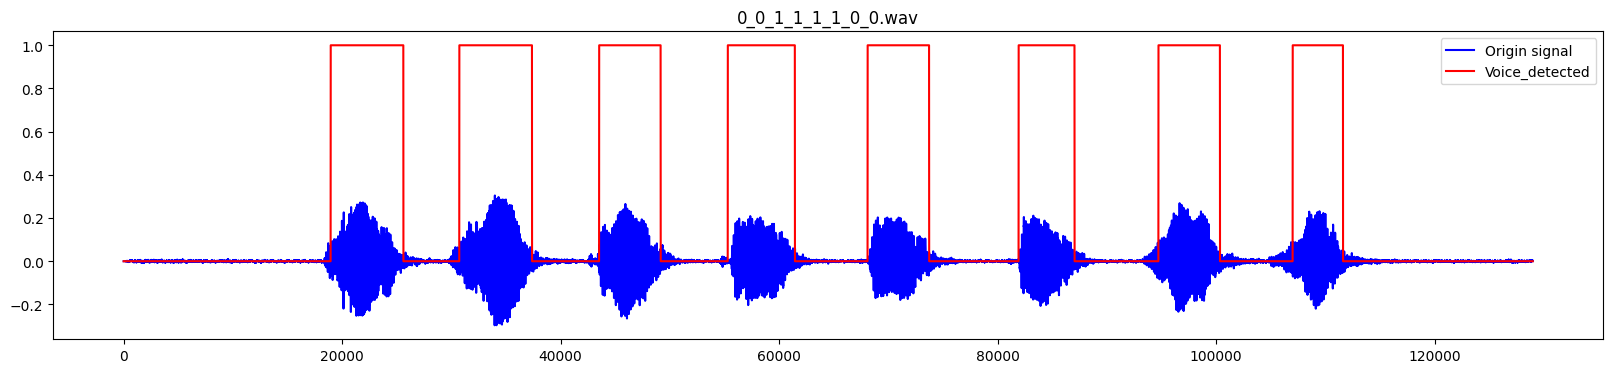

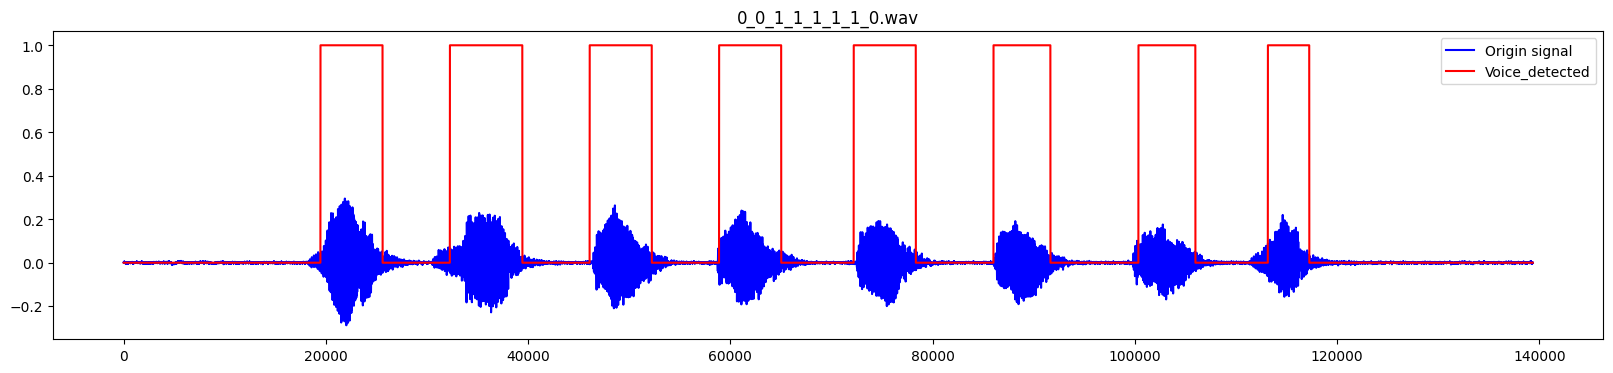

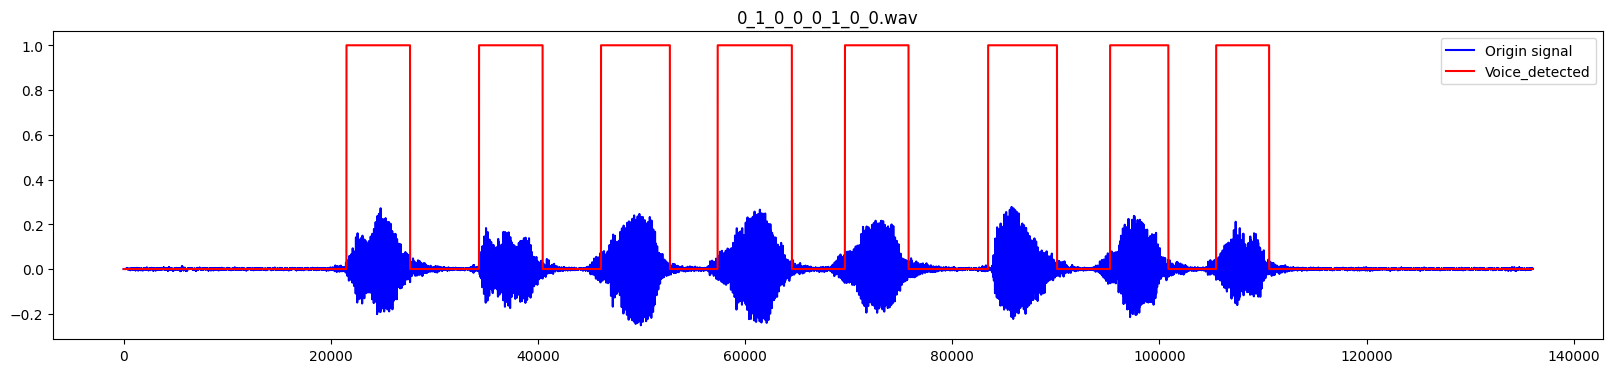

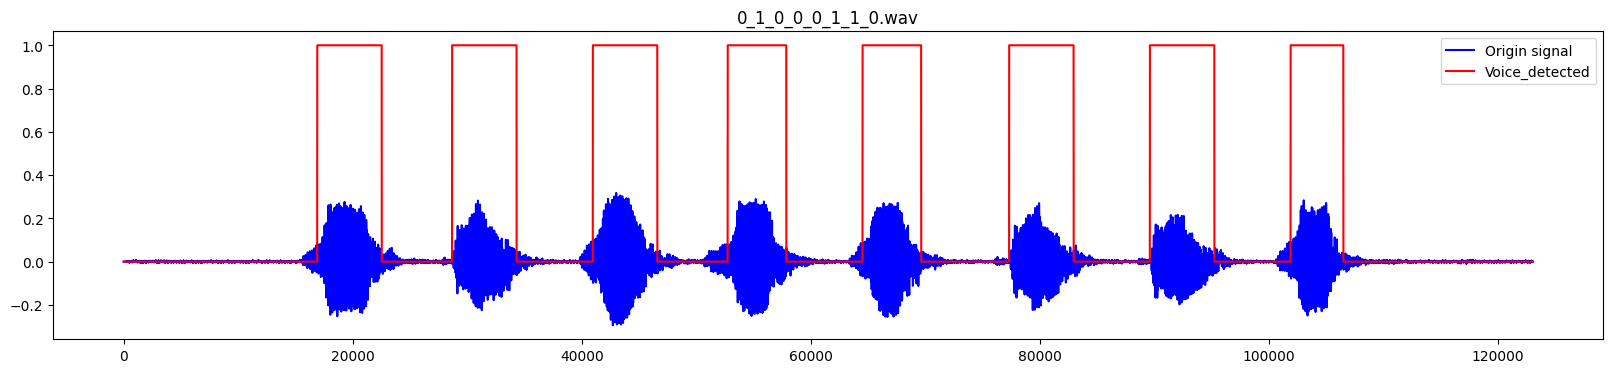

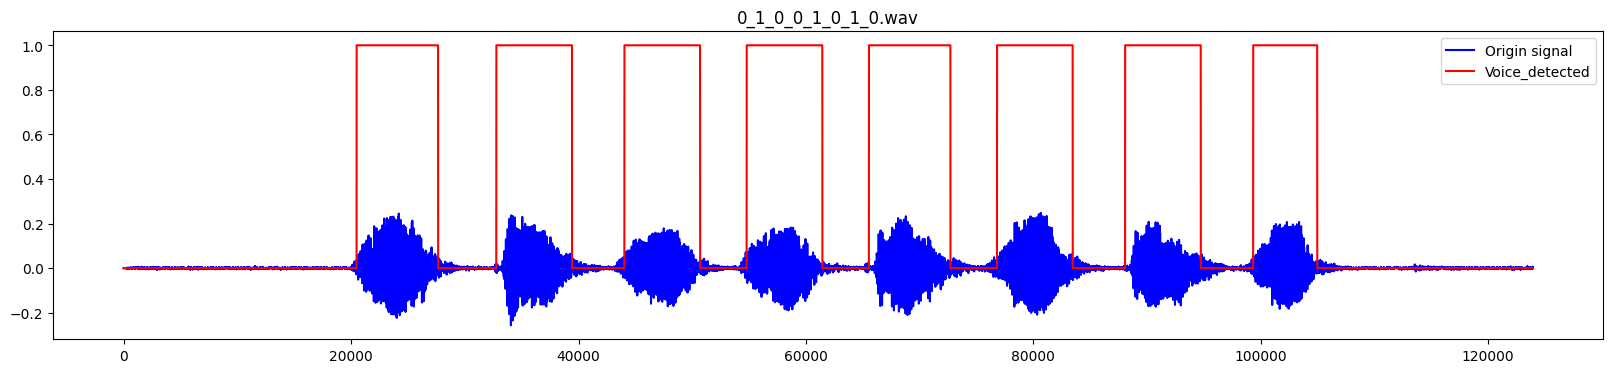

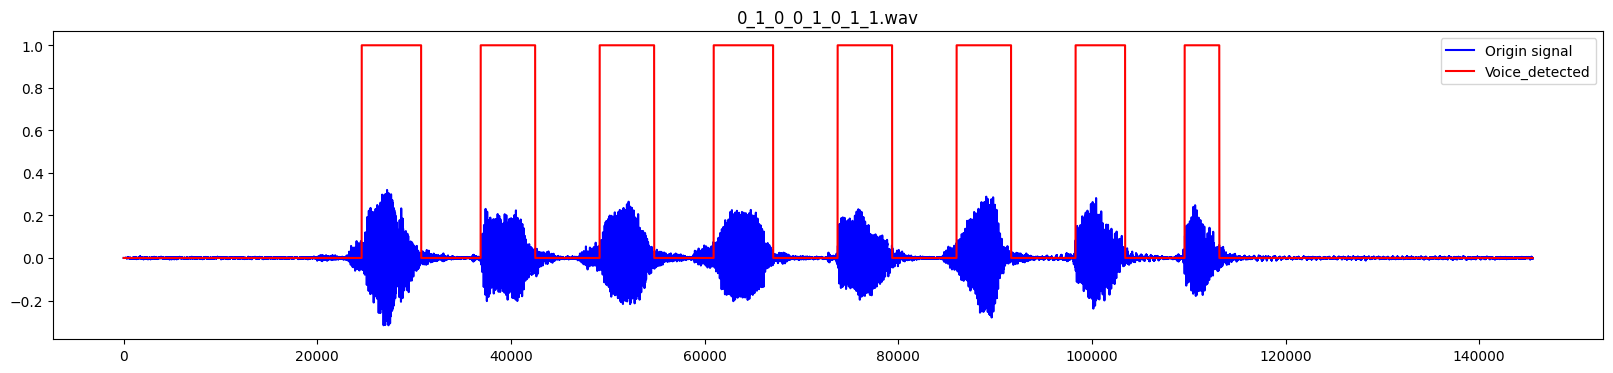

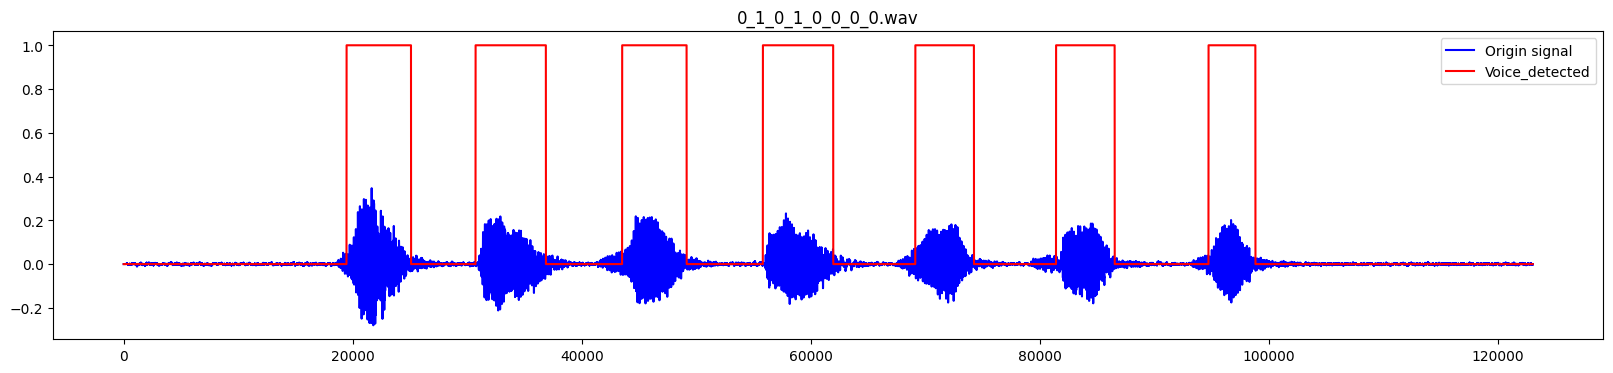

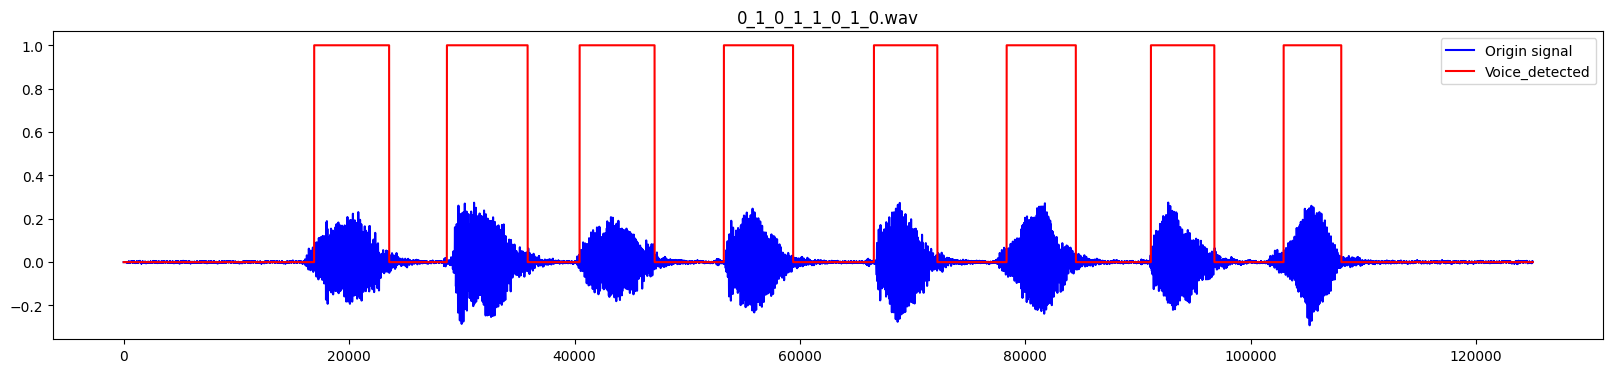

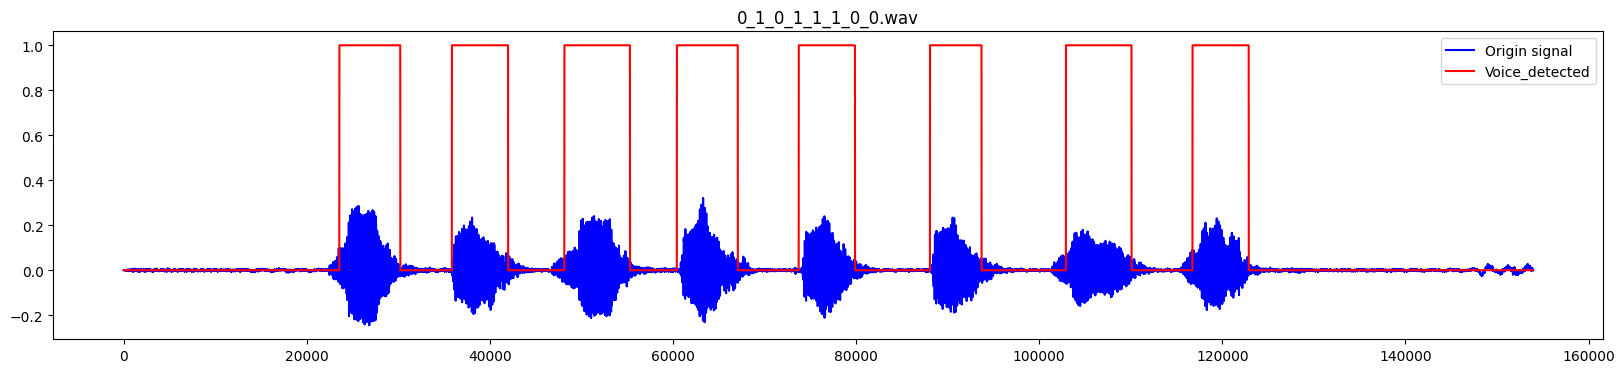

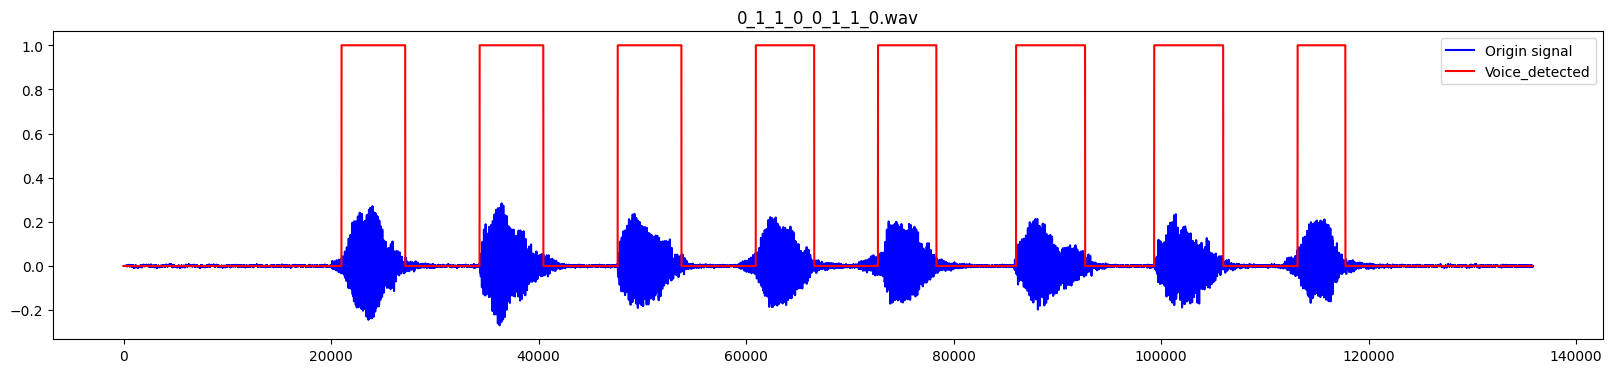

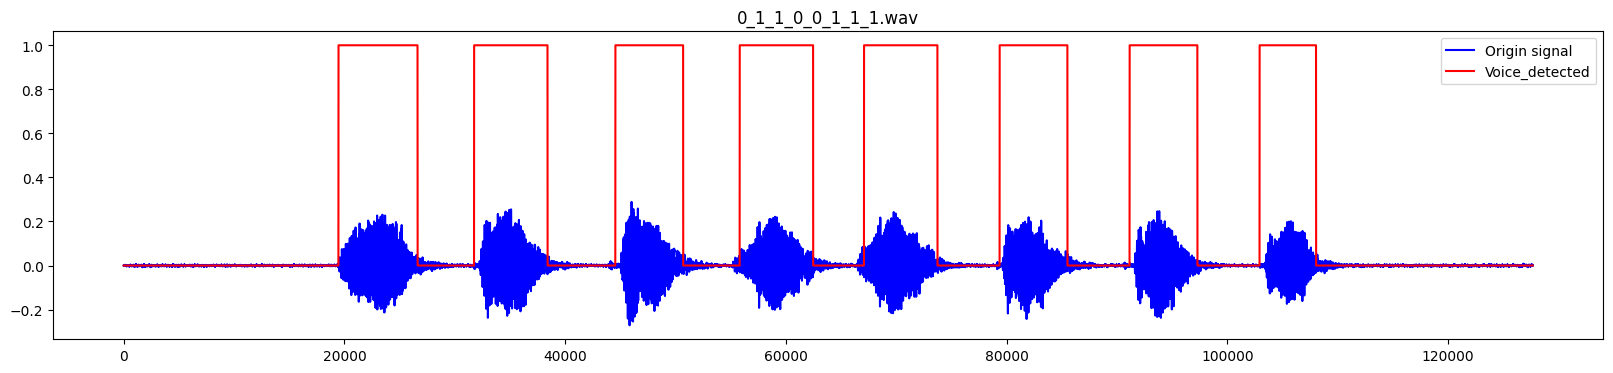

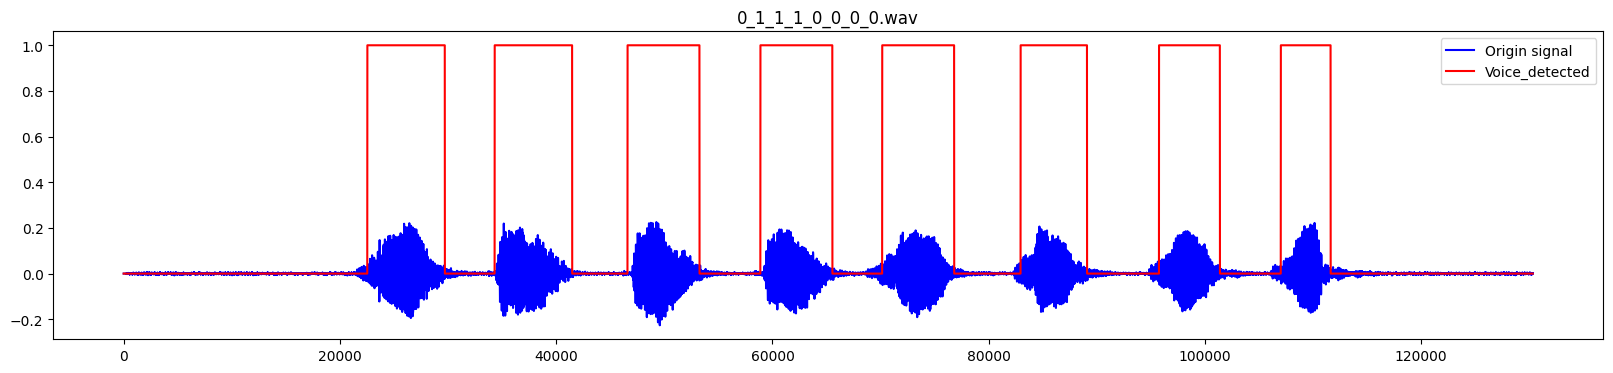

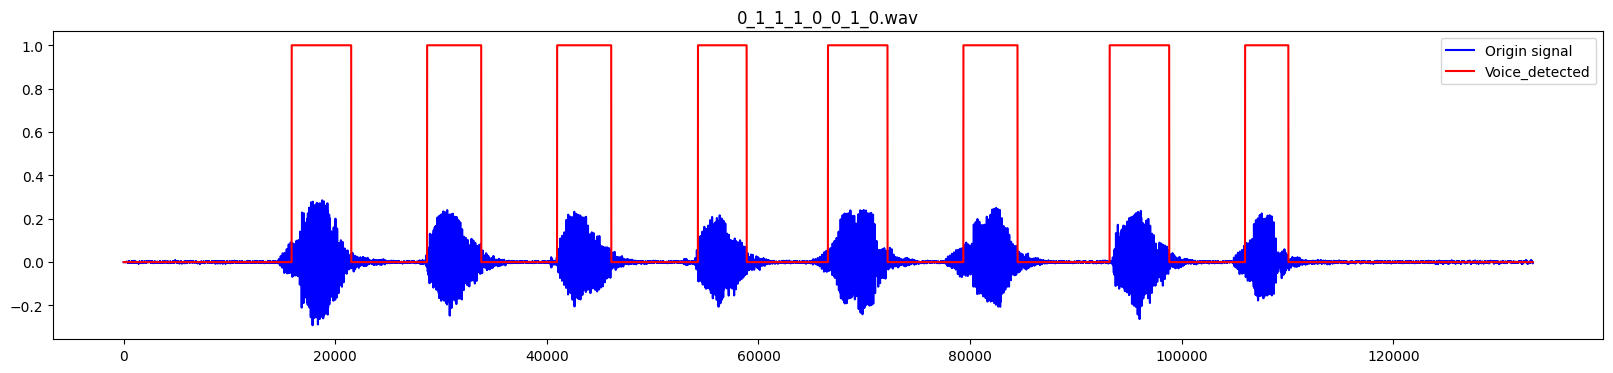

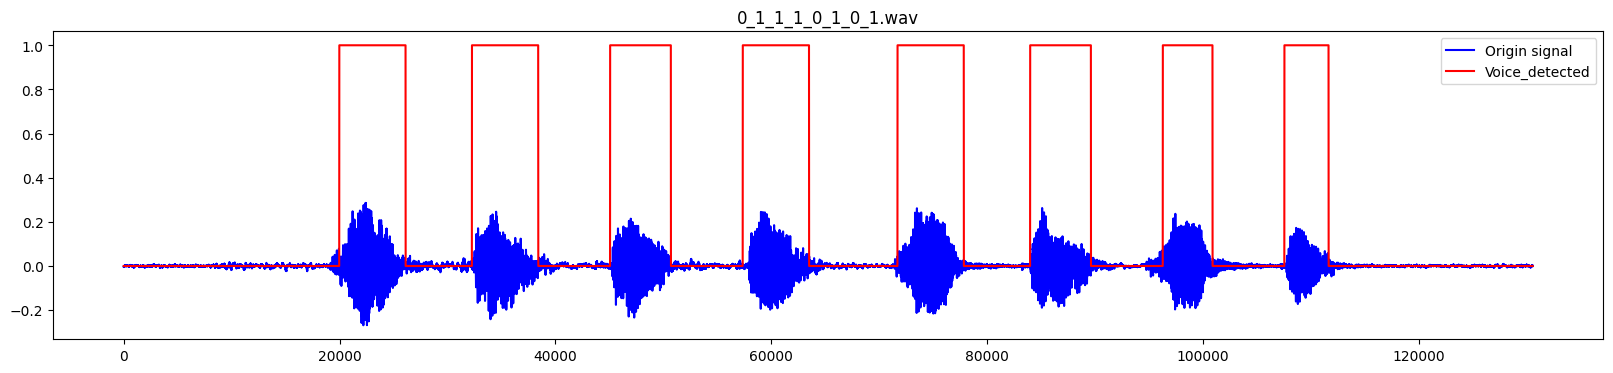

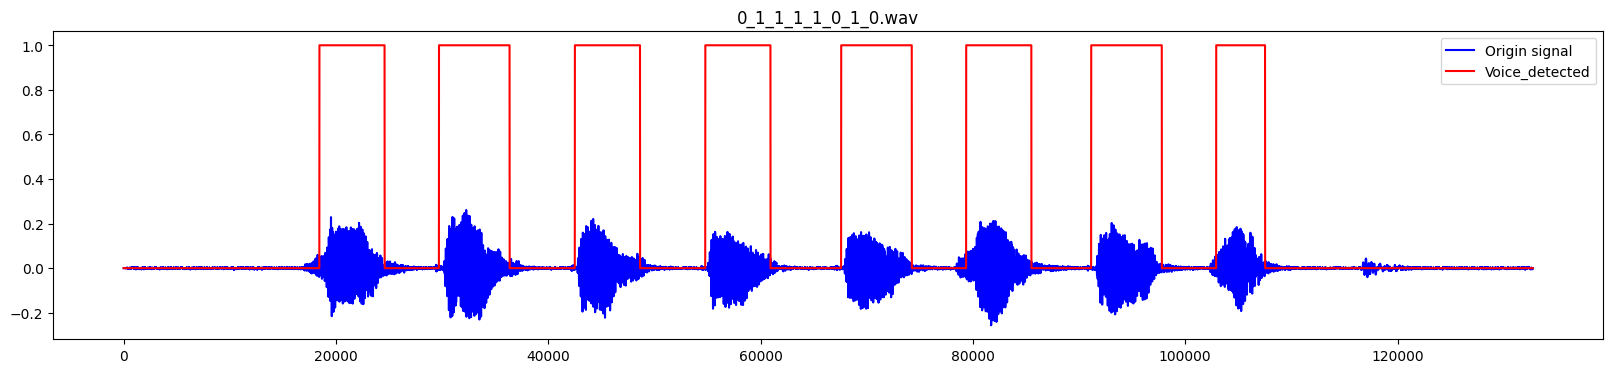

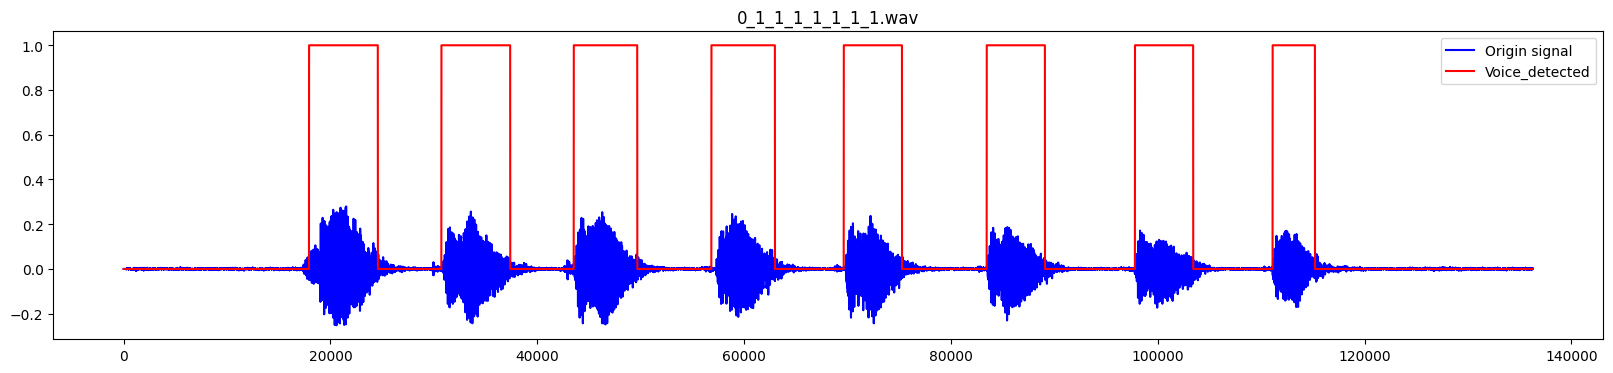

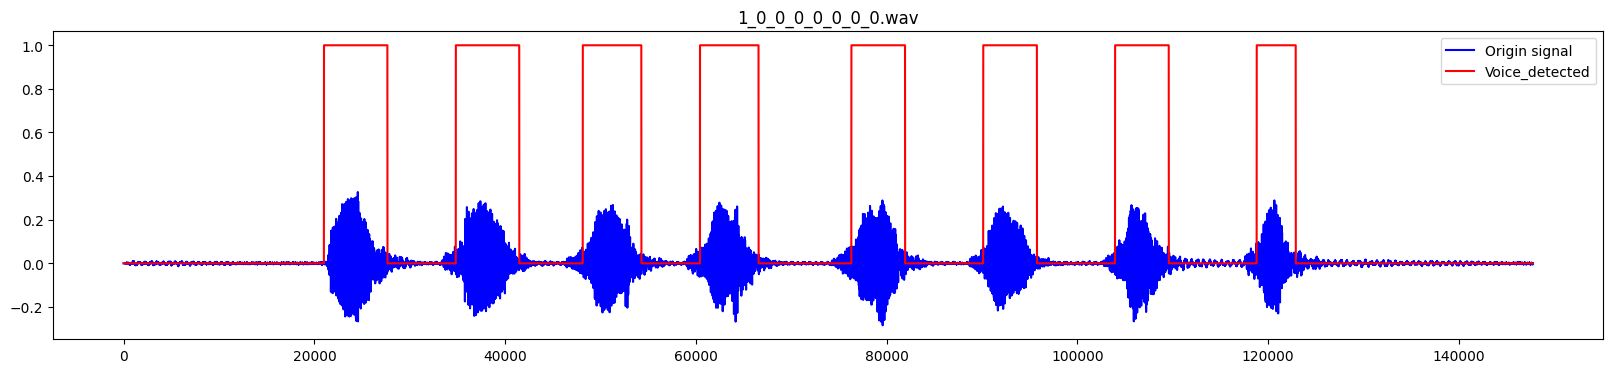

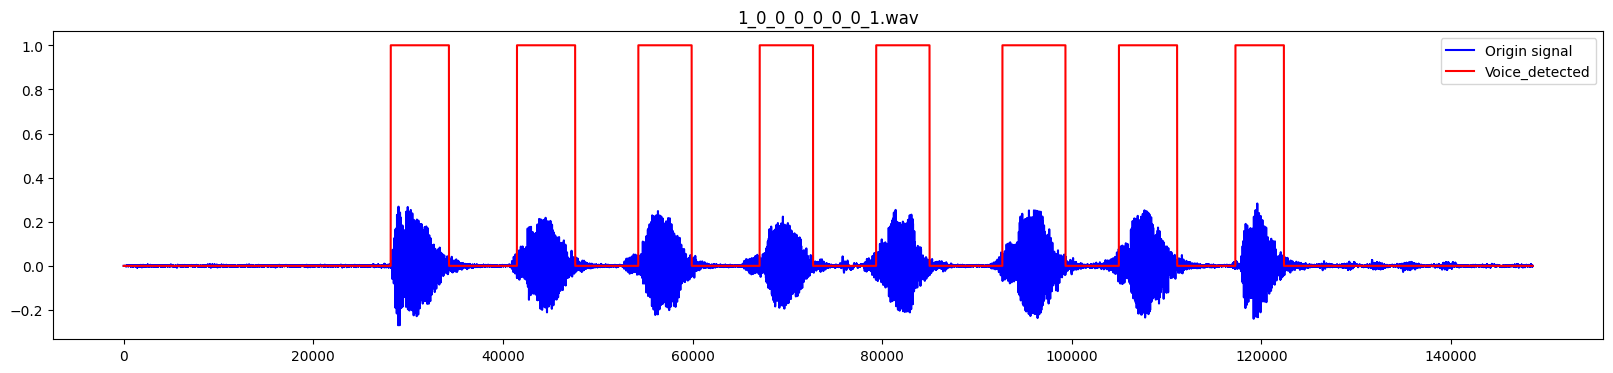

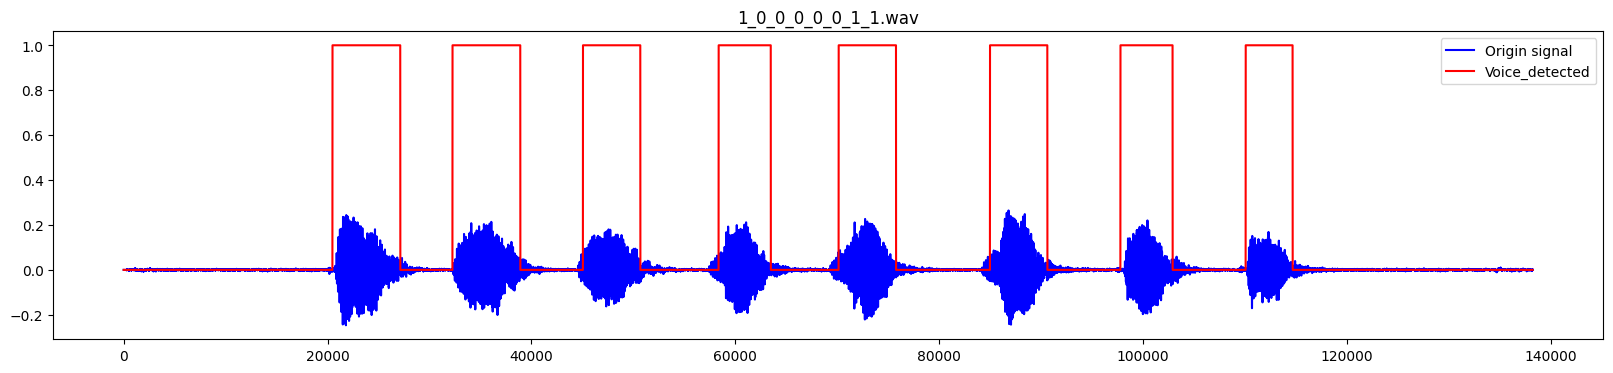

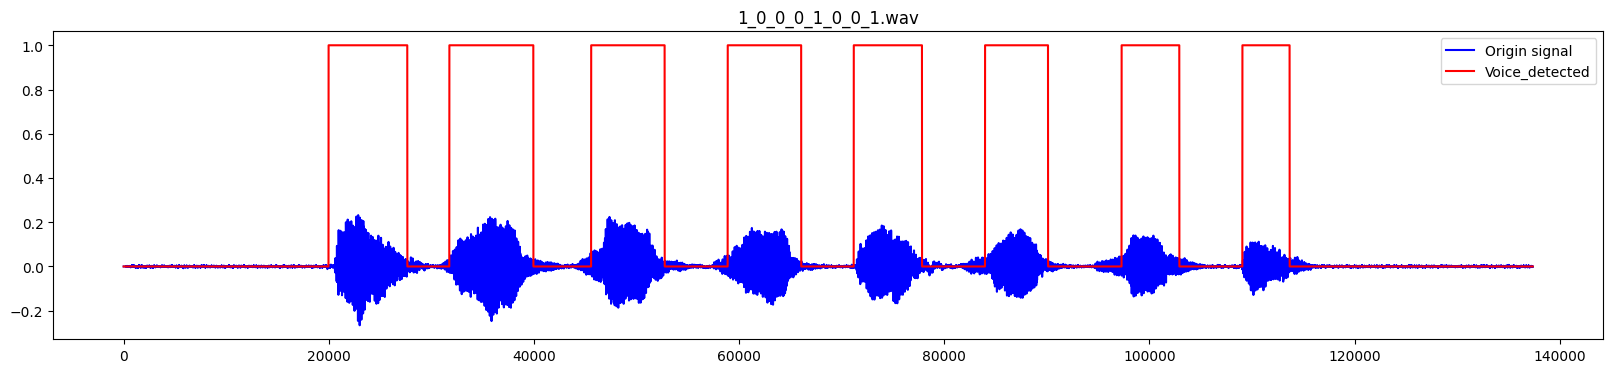

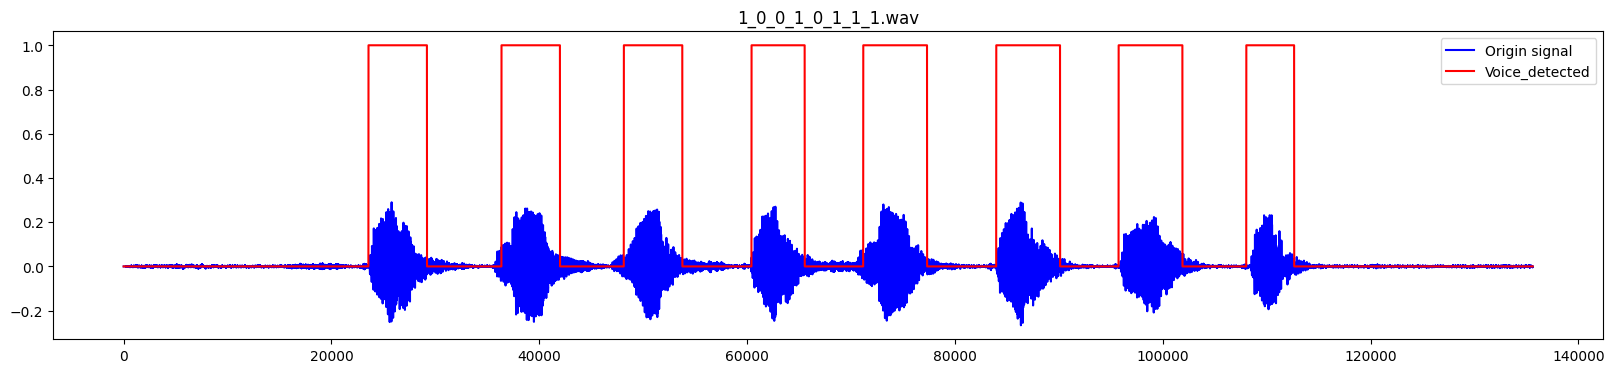

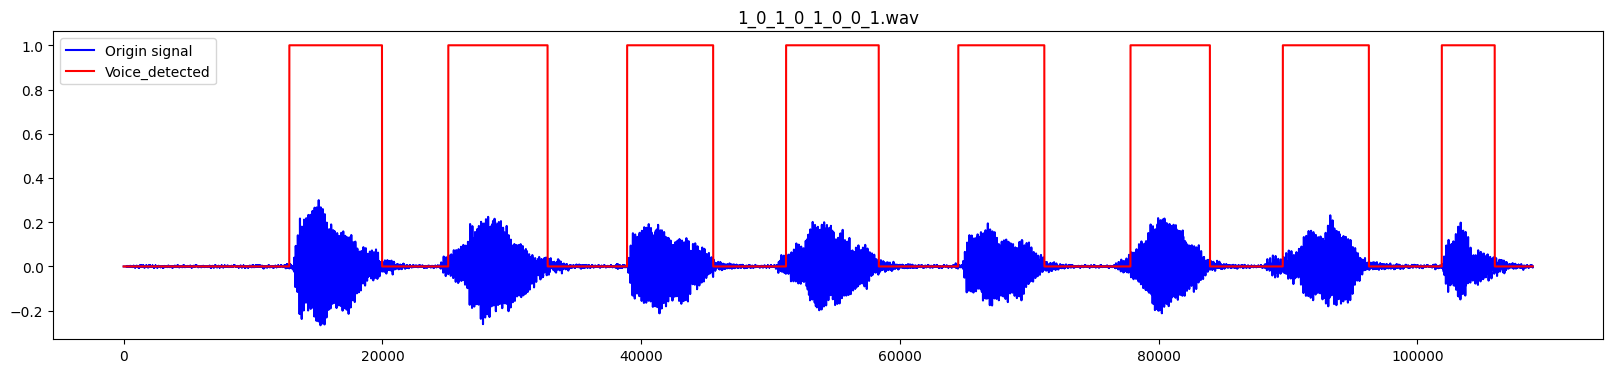

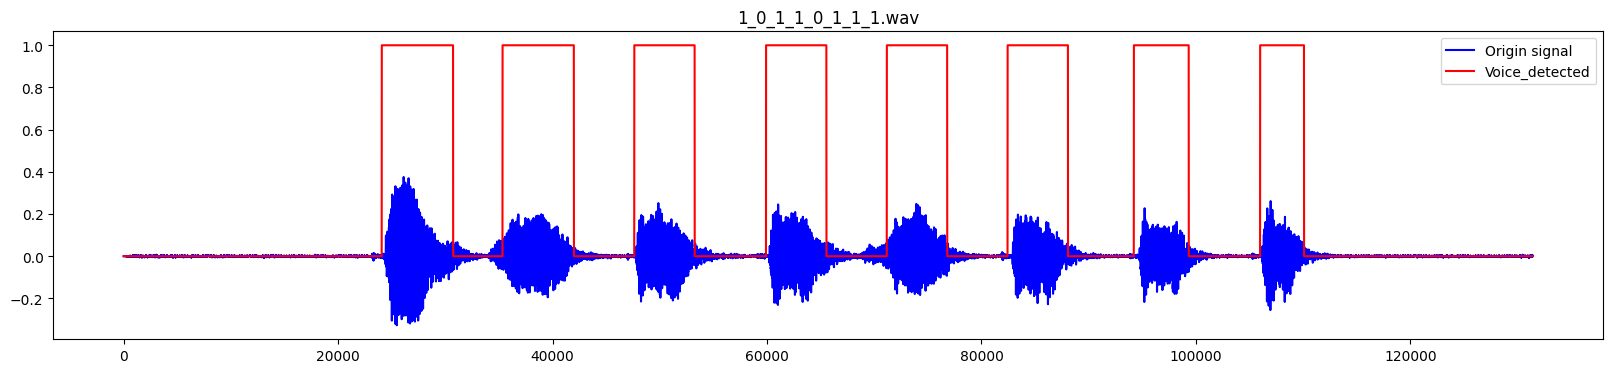

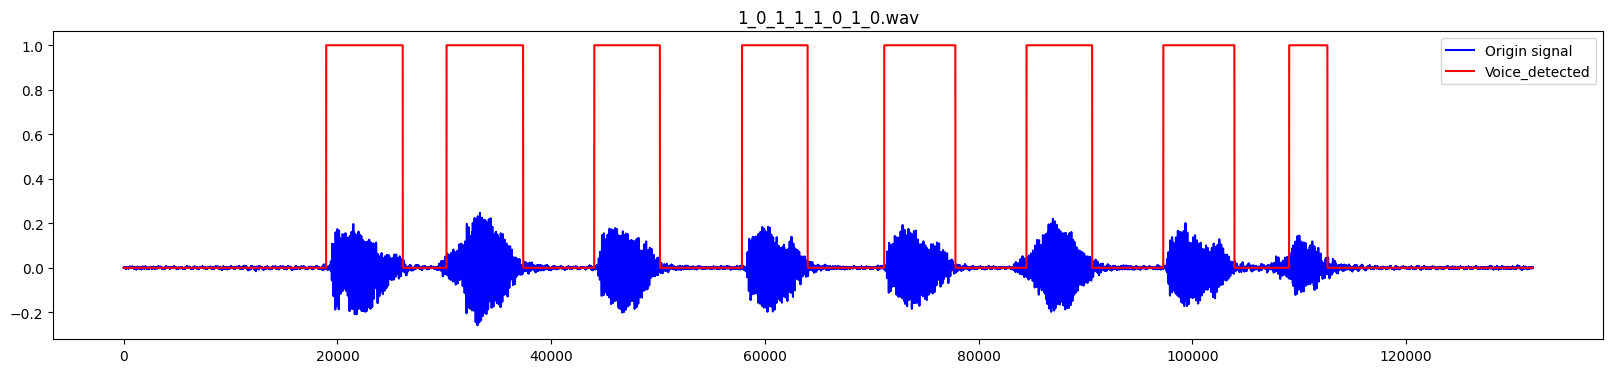

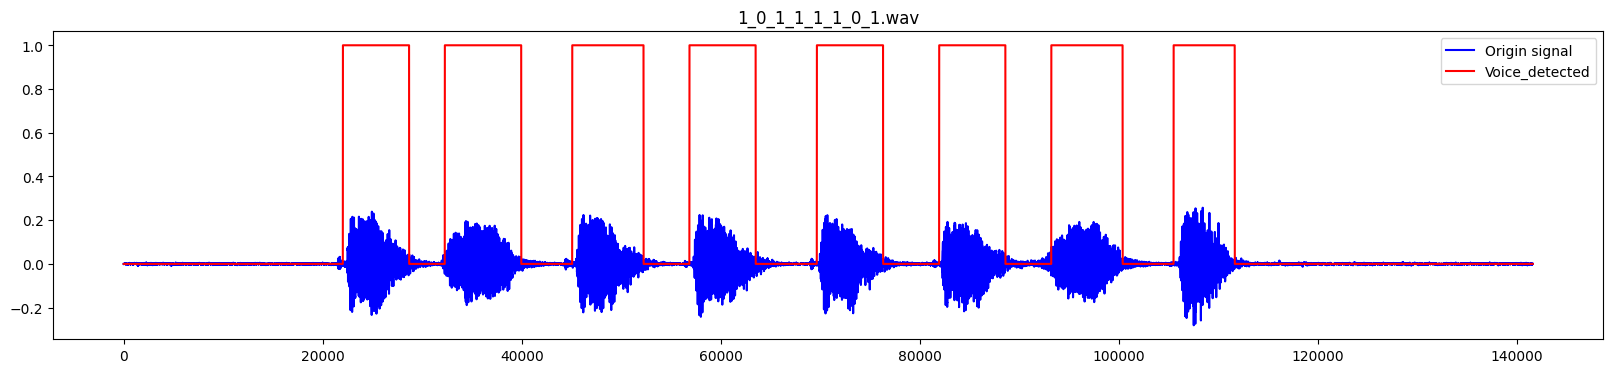

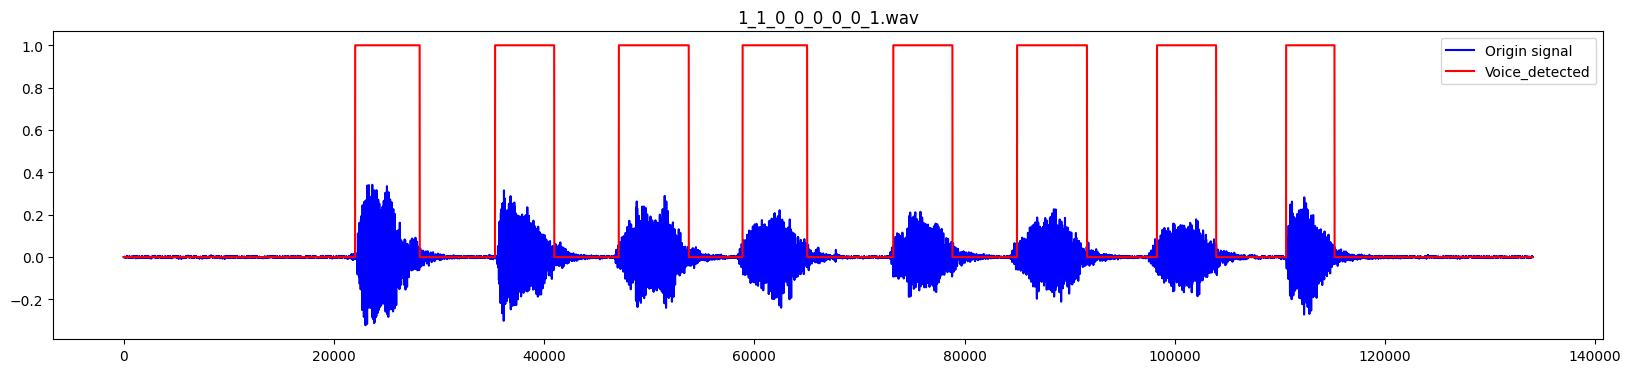

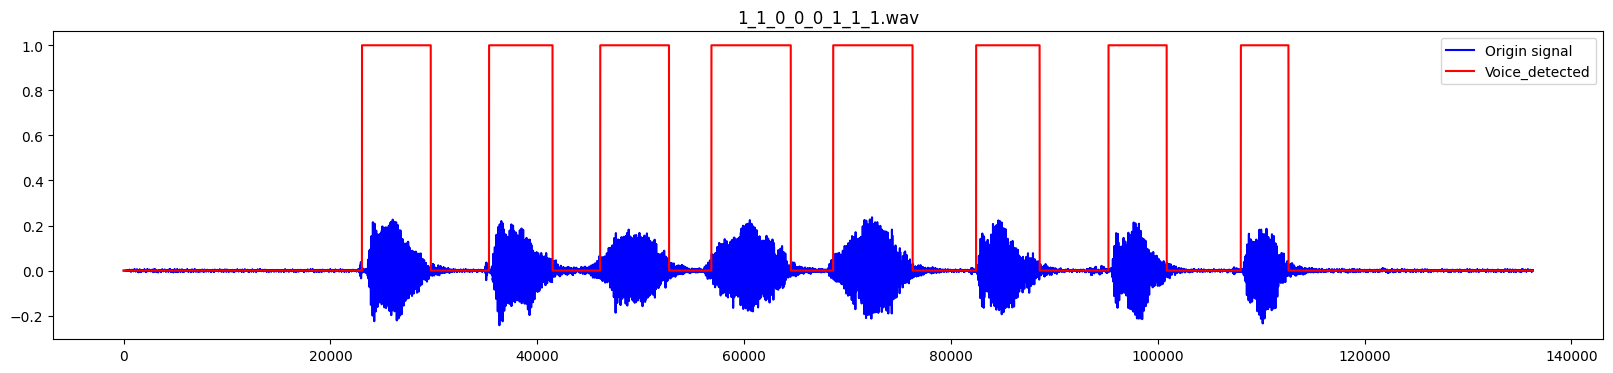

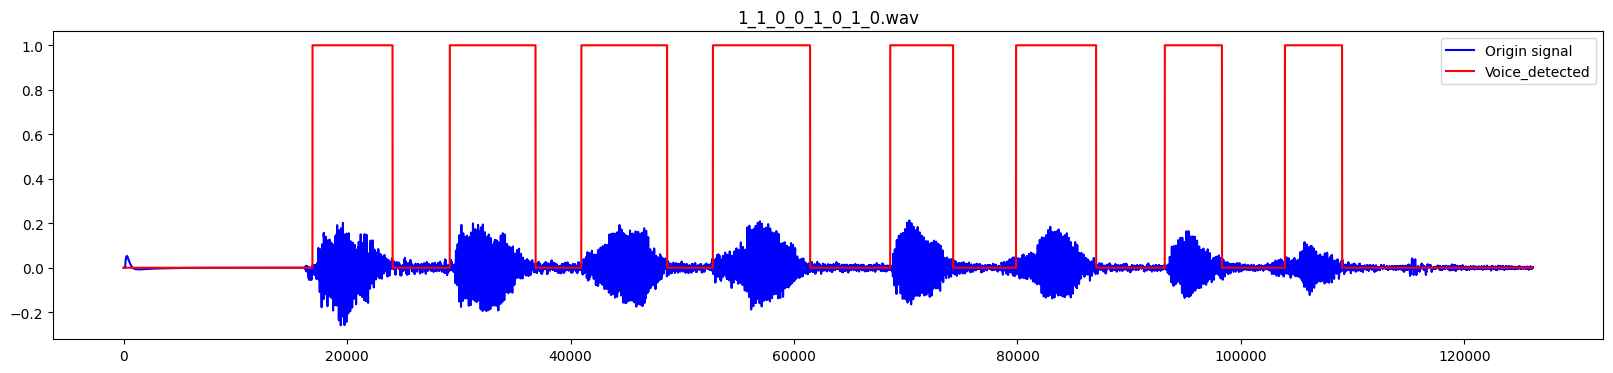

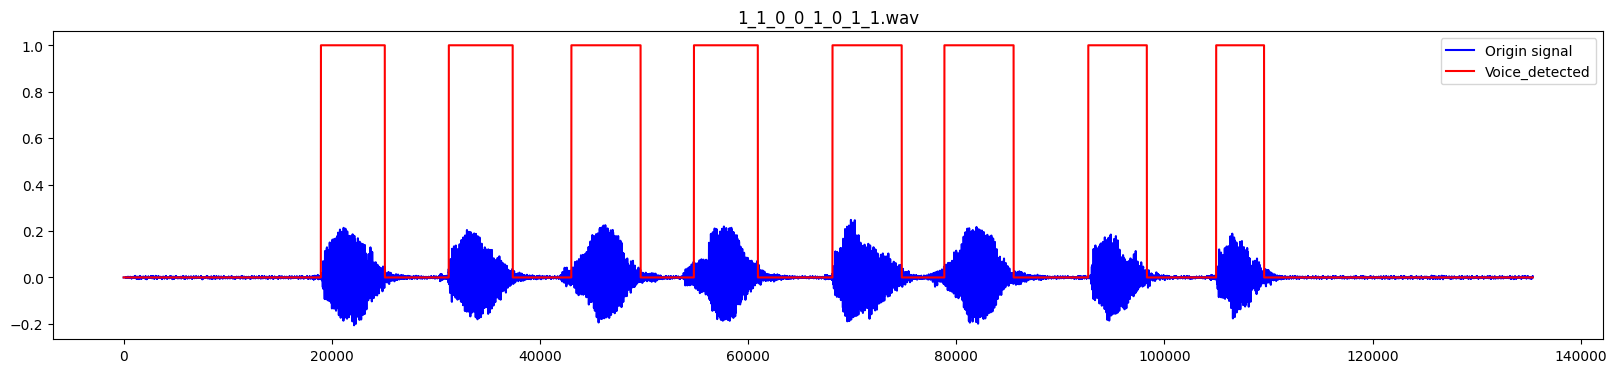

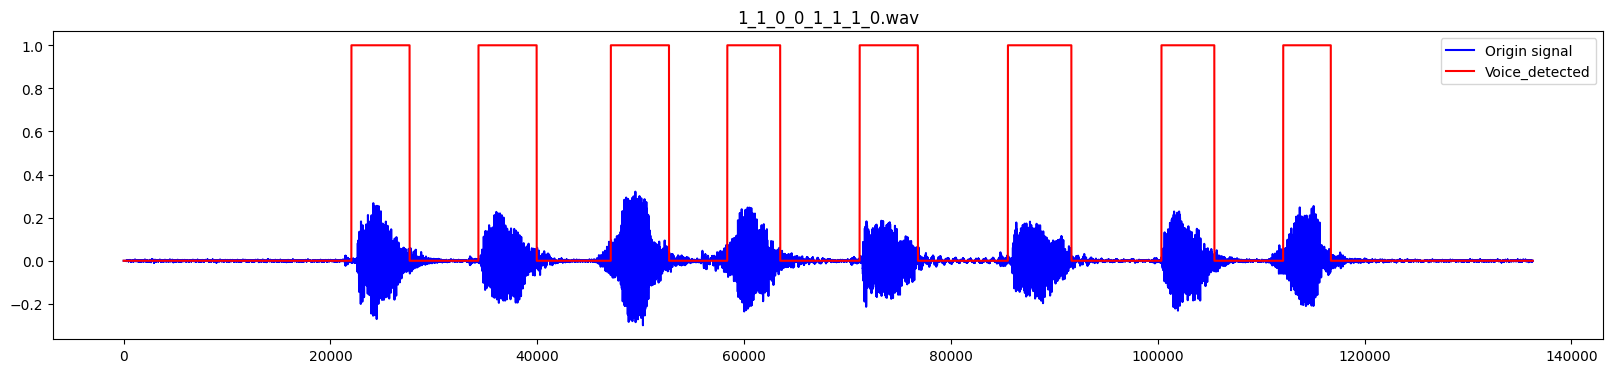

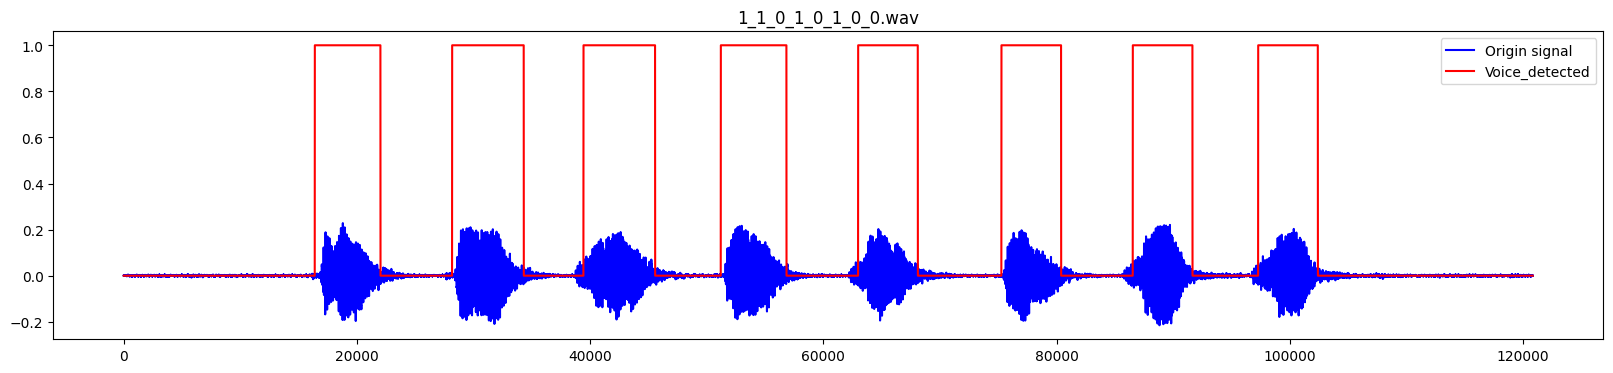

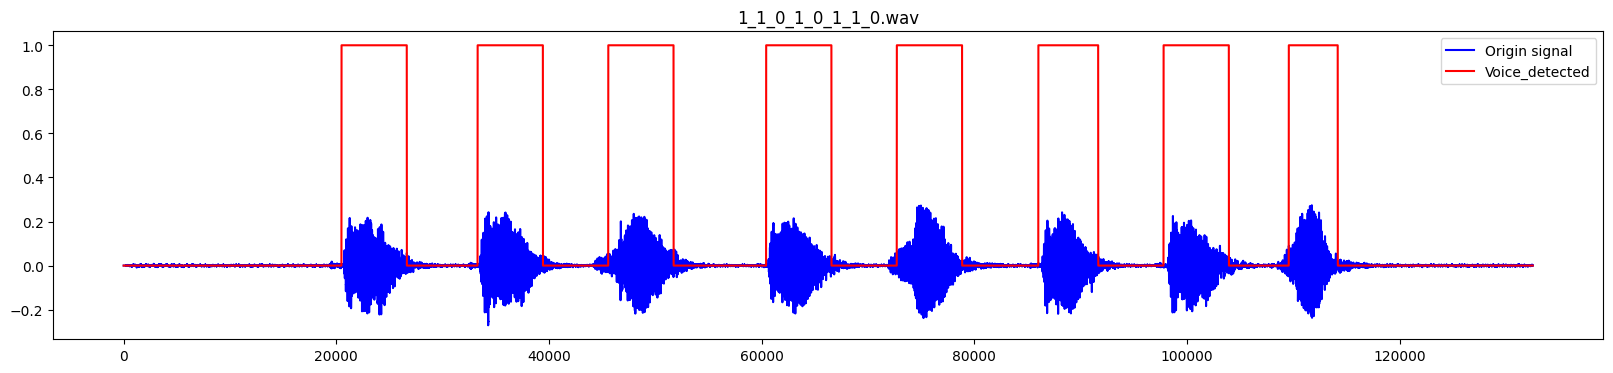

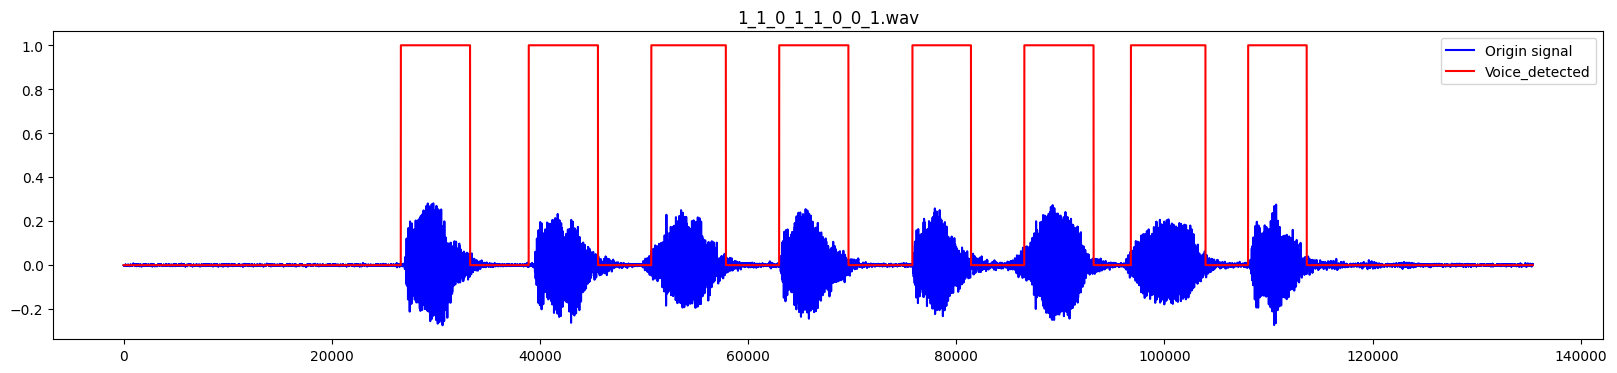

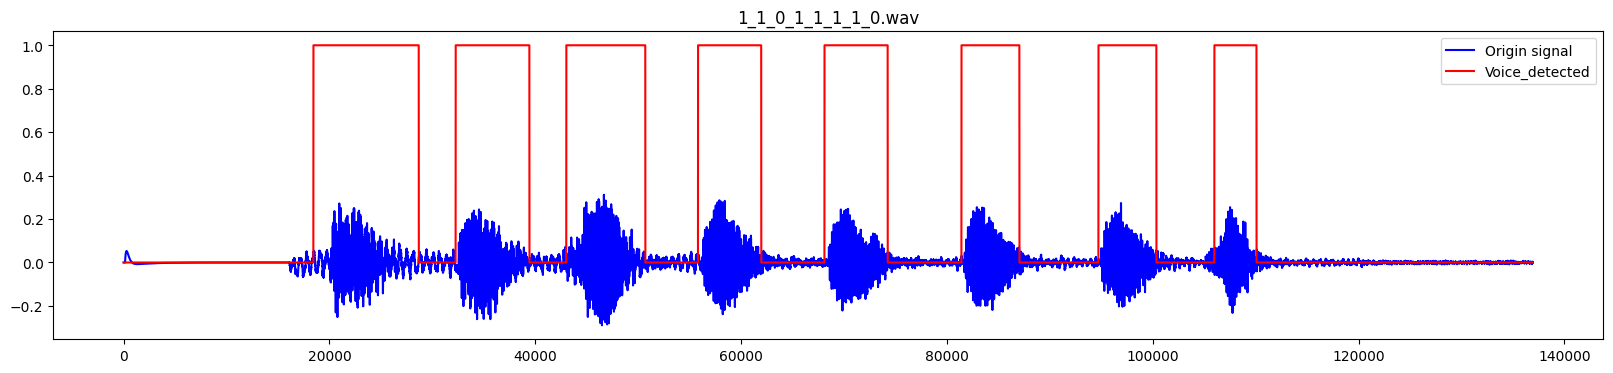

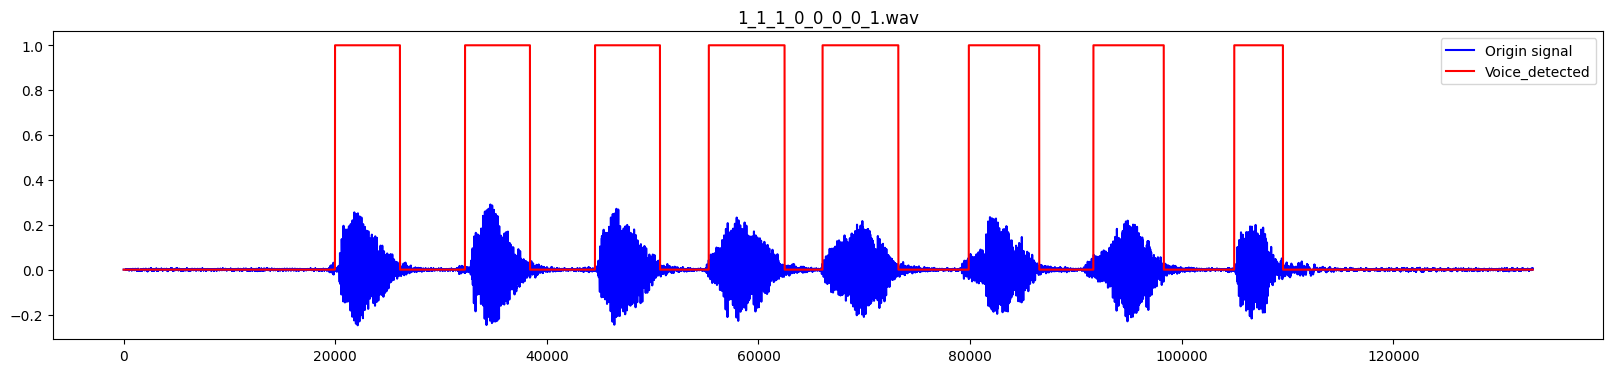

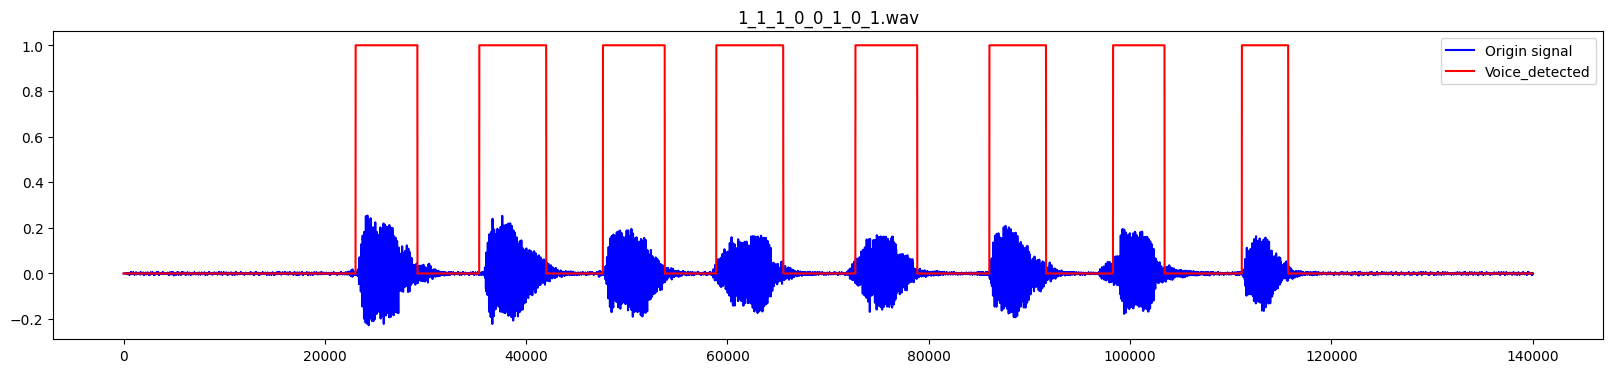

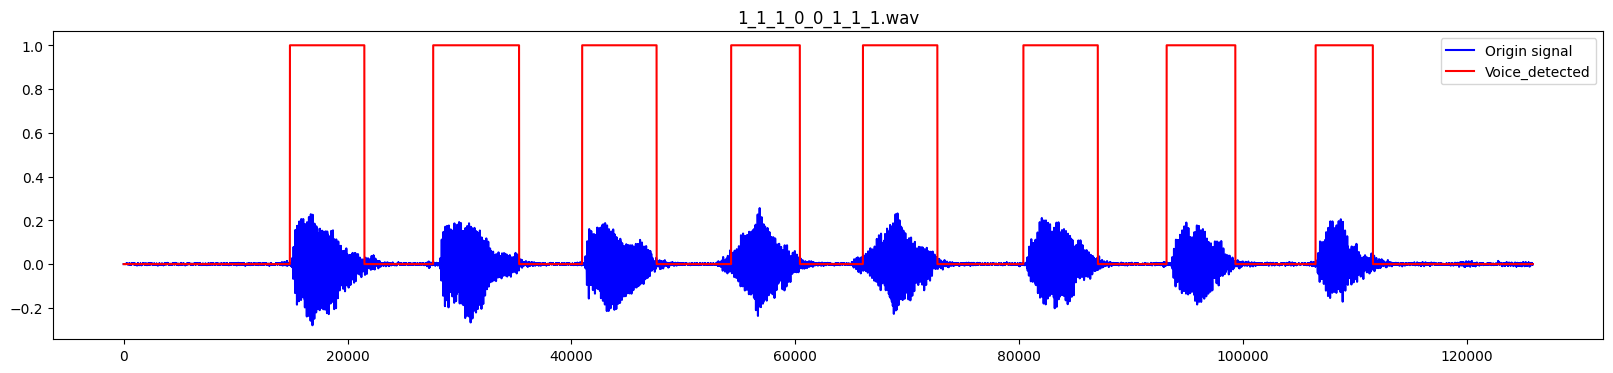

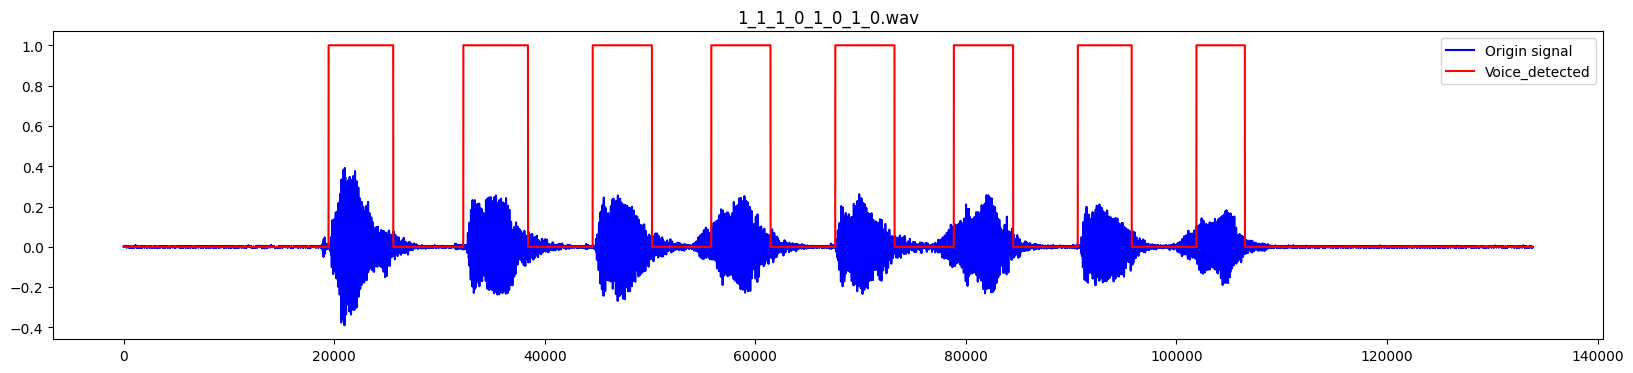

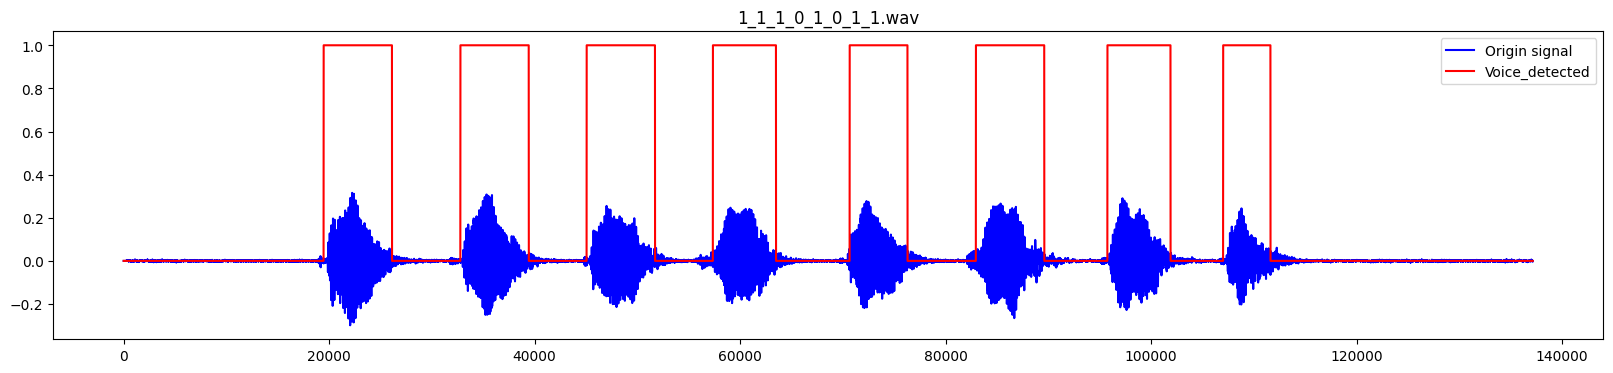

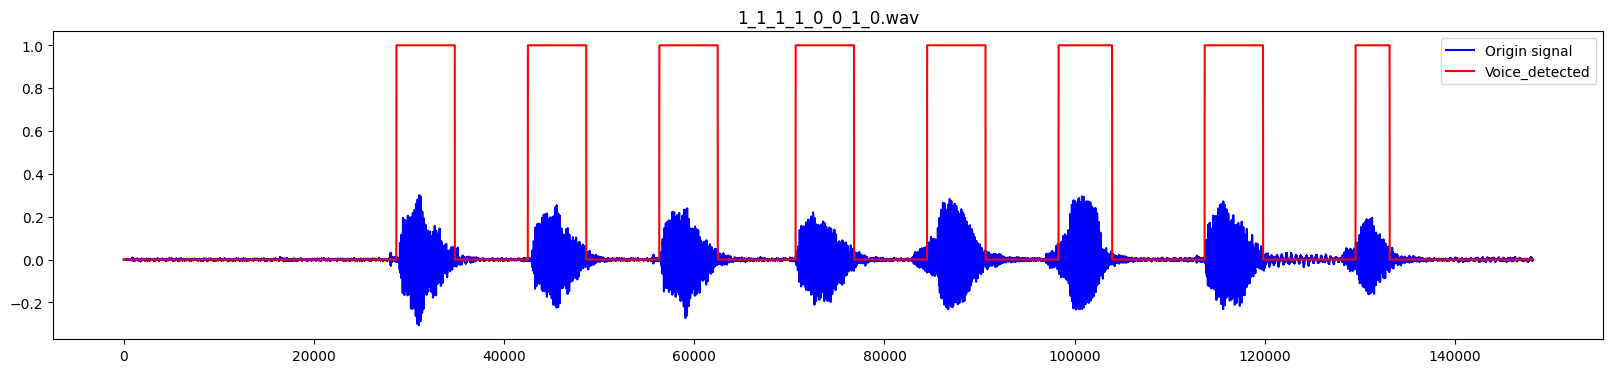

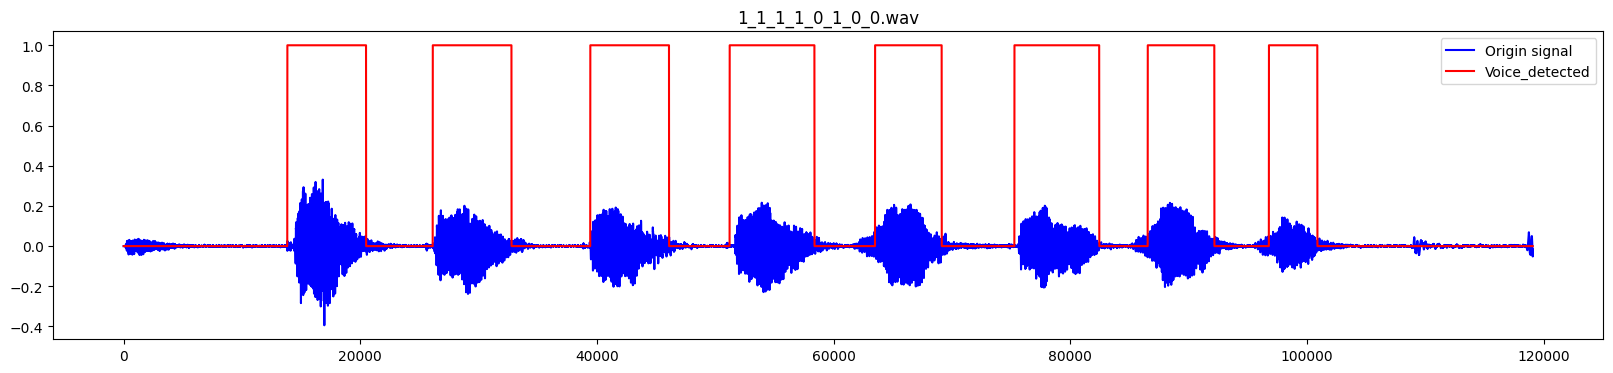

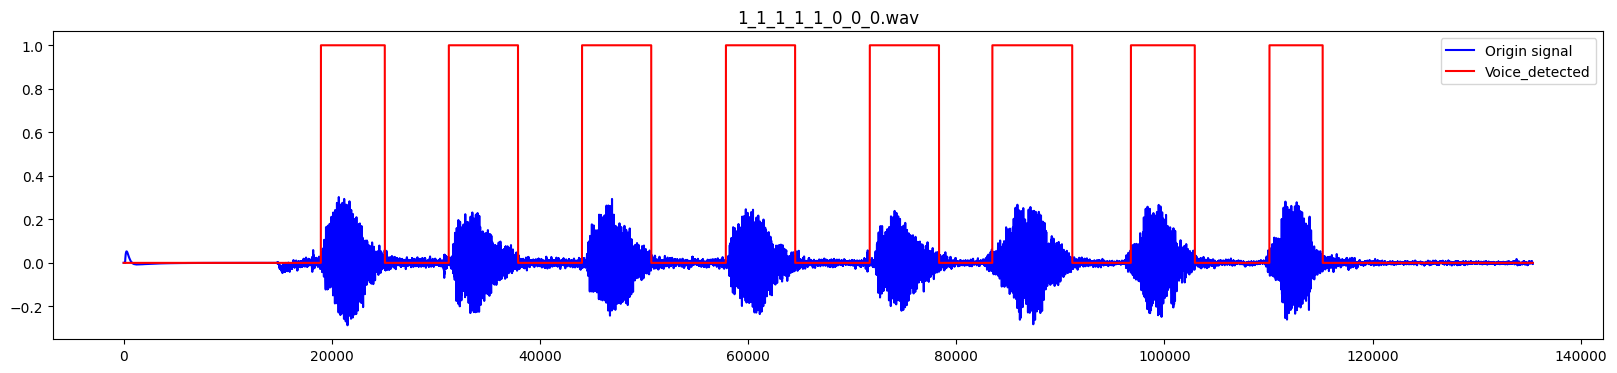

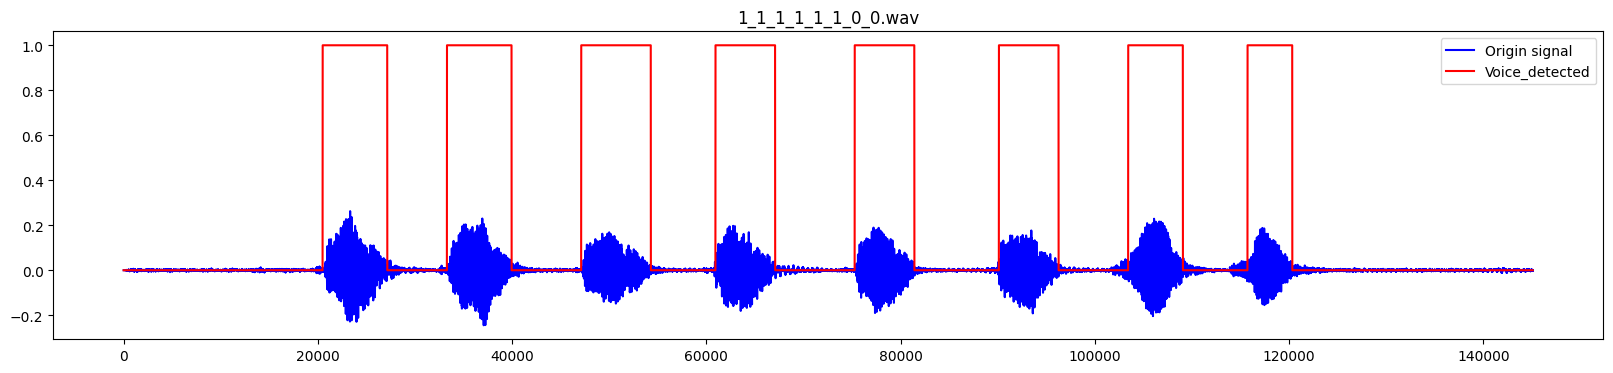

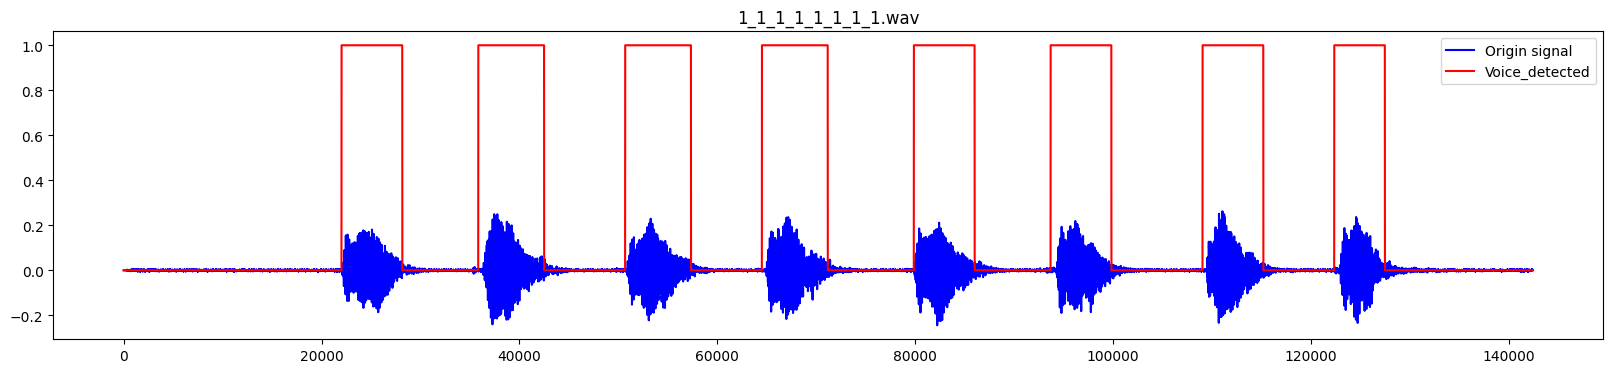

In [6]:
audio_test = range (0, len(files))
for i in audio_test:
    audio, sample_rate = librosa.load('../datasets/waves_yesno 2/' + files[i])
    plt.figure(figsize=(20,4))
    plt.plot(audio, label = 'Origin signal', color = 'blue')
    plt.title(files[i])
    
    speech_line = np.zeros(len(audio))
    
    for segment in vad_segments[i]:
        speech_line[segment[0]: segment[1]] = 1
        
    plt.plot(speech_line, color = 'red', label = 'Voice_detected')
    
    plt.legend()
    plt.show()

In [7]:
def make_dataset(samples, labels, vad_segments):
    """

    :param samples: Список аудио сигналов
    :param labels: Список меток (Например для файла '0_0_0_1_0_1_1_0.wav': [0, 0, 0, 1, 0, 1, 1, 0])
    :param vad_segments: Список сегментов для каждого аудио сигнала вида:
        [
            [[23996, 32539], [35410, 44925], ...,],
            [[22141, 30259], [34917, 42695], ...,],
            ...
        ]
    :return:
    """
    X, y = [], []
    # Проходим по каждому аудио сигналу
    for sample in range(len(samples)):
        # В аудио сигнале проходим по каждому сегменту с речью
        for segment in range(len(vad_segments[sample]) - 1):
            start = vad_segments[sample][segment][0]  # Начало сегмента
            stop = vad_segments[sample][segment][1]  # Конец сегмента
            voice = samples[sample][start:stop]  # Отрезаем сегмент с речью из аудио сигнала и применяем stft
            stft = librosa.stft(voice).mean(axis=1)
            stft_db = librosa.amplitude_to_db(abs(stft))

            X.append(stft_db)  # Добавляем спектрограмму с речью
            y.append(labels[sample][segment])  # Добавляем метку для этой спектрограммы

    return np.array(X), np.array(y)

In [8]:
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression

X, y = make_dataset(X, labels, vad_segments)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# SVM model
clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy (SVM):{accuracy}')


# LogisticRegression model
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy (LogisticRegression):{accuracy}')


Accuracy (SVM):1.0
Accuracy (LogisticRegression):1.0
